# Traitement des données qui concerne le polluant PM10

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode

In [2]:
import importlib
import PM10

# Recharger le module pour prendre en compte les modifications
importlib.reload(PM10)

# Importer la fonction depuis le fichier Python
from PM10 import fetch_and_process_pm10_data

# Utilisation de la fonction importée
dfPM10 = fetch_and_process_pm10_data()

# Vérifier si le DataFrame a été correctement récupéré et traité
if dfPM10 is not None:
    # Afficher les premières lignes du DataFrame dfPM10 pour vérifier les modifications
    print(dfPM10.head())

    # Afficher les types de colonnes pour vérifier les conversions
    print(dfPM10.dtypes)


Total records retrieved: 41770
                                  id code_polluant code_point_de_prelevement  \
0  2024-03-31 23:00:00FR23003_PM10_1            24              FR23003_PM10   
1  2024-03-31 23:00:00FR23068_PM10_4            24              FR23068_PM10   
2  2024-03-31 23:00:00FR23070_PM10_3            24              FR23070_PM10   
3  2024-03-31 23:00:00FR23078_PM10_2            24              FR23078_PM10   
4  2024-03-31 23:00:00FR23107_PM10_4            24              FR23107_PM10   

  code_station               nom_station               nom_commune  \
0      FR23003              LA MEGRETAIS                    Donges   
1      FR23068                   FROSSAY                   Frossay   
2      FR23070  SAINT ETIENNE DE MONTLUC  Saint-Etienne-De-Montluc   
3      FR23078             SAINT EXUPERY                    Cholet   
4      FR23107            LA CHAUVINIERE                    Nantes   

  code_commune departement_code   departement_nom  code_zone_affich

## Comparaison avec les valeurs de seuils

In [3]:
# Définition des seuils pour les particules PM10 en µg/m3
OBJECTIF_QUALITE_PM10 = 30  # en moyenne annuelle
VALEUR_LIMITE_ANNUELLE_PM10 = 40  # en moyenne annuelle

# Afficher les seuils définis
print(f"Objectif de qualité PM10 : {OBJECTIF_QUALITE_PM10} µg/m3 (en moyenne annuelle)")
print(f"Valeur limite annuelle PM10 : {VALEUR_LIMITE_ANNUELLE_PM10} µg/m3 (en moyenne annuelle)")


Objectif de qualité PM10 : 30 µg/m3 (en moyenne annuelle)
Valeur limite annuelle PM10 : 40 µg/m3 (en moyenne annuelle)


Création d'une variable cible qui vaut 1 si la valeur est supérieure au seuil et 0 sinon
On ajoute ces colonnes au dataframe

In [4]:
# Convertir les colonnes de date en format datetime
dfPM10['date_heure_tu'] = pd.to_datetime(dfPM10['date_heure_tu'])

# Ajouter des colonnes de comparaison avec les seuils (variable cible)
dfPM10['cible_objectif_qualite_PM10'] = (dfPM10['valeur'] > OBJECTIF_QUALITE_PM10).astype(int)
dfPM10['cible_valeur_limite_annuelle_PM10'] = (dfPM10['valeur'] > VALEUR_LIMITE_ANNUELLE_PM10).astype(int)

# Afficher les premières lignes du DataFrame avec les nouvelles colonnes de comparaison
print(dfPM10.head())

# Sauvegarder le DataFrame avec les nouvelles colonnes de comparaison
dfPM10.to_pickle('PM10_with_comparison.pkl')


                                  id  code_polluant code_point_de_prelevement  \
0  2024-03-31 23:00:00FR23003_PM10_1             24              FR23003_PM10   
1  2024-03-31 23:00:00FR23068_PM10_4             24              FR23068_PM10   
2  2024-03-31 23:00:00FR23070_PM10_3             24              FR23070_PM10   
4  2024-03-31 23:00:00FR23107_PM10_4             24              FR23107_PM10   
5  2024-03-31 23:00:00FR23110_PM10_3             24              FR23110_PM10   

  code_station               nom_station               nom_commune  \
0      FR23003              LA MEGRETAIS                    donges   
1      FR23068                   FROSSAY                   frossay   
2      FR23070  SAINT ETIENNE DE MONTLUC  saint-etienne-de-montluc   
4      FR23107            LA CHAUVINIERE                    nantes   
5      FR23110                 LEON BLUM             saint-nazaire   

   code_commune  departement_code   departement_nom  code_zone_affichage  \
0         44052 

### Distribution des variables cibles : 

In [5]:
# Afficher le nombre de valeurs 0 et 1 dans la colonne 'cible_objectif_qualite_PM10'
print(dfPM10['cible_objectif_qualite_PM10'].value_counts())
print(dfPM10['cible_valeur_limite_annuelle_PM10'].value_counts())


cible_objectif_qualite_PM10
0    38108
1     2666
Name: count, dtype: int64
cible_valeur_limite_annuelle_PM10
0    39943
1      831
Name: count, dtype: int64


Observations : 
- On remarque ici qu'aucune valeur ne dépasse le seuil, nous avons donc fait le choix de modifier ce dernier de manière arbitraire pour rendre l'exercice plus intéressant, toutes les valeurs seront donc divisées par 2
- De plus pour visualiser les résultats par mois, on décide de créer une valeur de seuil mensuelle nommé "OBJECTIF_QUALITE_PM10_MENSUEL" et qui aura pour valeur 35 (car la moyenne annuelle étant à 30 et la valeur limite annuelle étant à 40 on prend l'entre deux) qu'on va venir diviser par 2 pour avoir des résultats, on va prendre 18 pour arrondir à la valeur au-dessus

In [6]:
# Définition des nouveaux seuils pour les particules PM10 en µg/m3
OBJECTIF_QUALITE_PM10_MENSUEL = 15 #en moyenne mensuelle, 30 valeur d'origine
SEUIL_INFO_RECO = 25 #en moyenne sur 24H, 50 valeur d'origine
SEUIL_ALERTE = 40 #en moyenne sur 24H, 80 valeur d'origine

# Afficher les nouveaux seuils définis
print(f"Objectif de qualité PM10 mensuelle : {OBJECTIF_QUALITE_PM10_MENSUEL} µg/m3 (en moyenne mensuelle)")
print(f"Seuil d'information et de recommandation : {SEUIL_INFO_RECO} µg/m3 (en moyenne sur 24H)")
print(f"Seuils d'alerte : {SEUIL_ALERTE} µg/m3 (en moyenne horaire sur 24H)")

Objectif de qualité PM10 mensuelle : 15 µg/m3 (en moyenne mensuelle)
Seuil d'information et de recommandation : 25 µg/m3 (en moyenne sur 24H)
Seuils d'alerte : 40 µg/m3 (en moyenne horaire sur 24H)


In [7]:
# Convertir les colonnes de date en format datetime
dfPM10['date_heure_tu'] = pd.to_datetime(dfPM10['date_heure_tu'])

# Ajouter des colonnes de comparaison avec les seuils (variable cible)
dfPM10['cible_objectif_qualite_PM10'] = (dfPM10['valeur'] > OBJECTIF_QUALITE_PM10).astype(int)
dfPM10['cible_valeur_limite_annuelle_PM10'] = (dfPM10['valeur'] > VALEUR_LIMITE_ANNUELLE_PM10).astype(int)
dfPM10['cible_objectif_qualite_PM10_mensuelle'] = (dfPM10['valeur'] > OBJECTIF_QUALITE_PM10_MENSUEL).astype(int)

dfPM10['cible_seuil_info_reco'] = (dfPM10['valeur'] > SEUIL_INFO_RECO).astype(int)
dfPM10['cible_seuils_alerte'] = (dfPM10['valeur'] > SEUIL_ALERTE).astype(int)

# Afficher les premières lignes du DataFrame avec les nouvelles colonnes de comparaison
print(dfPM10.head())

# Sauvegarder le DataFrame avec les nouvelles colonnes de comparaison
dfPM10.to_pickle('PM10_with_comparison.pkl')

                                  id  code_polluant code_point_de_prelevement  \
0  2024-03-31 23:00:00FR23003_PM10_1             24              FR23003_PM10   
1  2024-03-31 23:00:00FR23068_PM10_4             24              FR23068_PM10   
2  2024-03-31 23:00:00FR23070_PM10_3             24              FR23070_PM10   
4  2024-03-31 23:00:00FR23107_PM10_4             24              FR23107_PM10   
5  2024-03-31 23:00:00FR23110_PM10_3             24              FR23110_PM10   

  code_station               nom_station               nom_commune  \
0      FR23003              LA MEGRETAIS                    donges   
1      FR23068                   FROSSAY                   frossay   
2      FR23070  SAINT ETIENNE DE MONTLUC  saint-etienne-de-montluc   
4      FR23107            LA CHAUVINIERE                    nantes   
5      FR23110                 LEON BLUM             saint-nazaire   

   code_commune  departement_code   departement_nom  code_zone_affichage  ...  \
0         4

In [8]:
# S'assurer que la colonne date_heure_tu est bien au format datetime
dfPM10['date_heure_tu'] = pd.to_datetime(dfPM10['date_heure_tu'])

# Vérifier que chaque enregistrement est horodaté à l'heure près
dfPM10['hour'] = dfPM10['date_heure_tu'].dt.hour

# Comparaison de la valeur avec les seuils d'information et d'alerte
dfPM10['cible_seuil_info_reco'] = (dfPM10['valeur'] > SEUIL_INFO_RECO).astype(int)
dfPM10['cible_seuil_alerte'] = (dfPM10['valeur'] > SEUIL_ALERTE).astype(int)

# Afficher un échantillon des données pour vérifier les résultats
print(dfPM10[['date_heure_tu', 'valeur', 'cible_seuil_info_reco', 'cible_seuil_alerte']].head())


              date_heure_tu  valeur  cible_seuil_info_reco  cible_seuil_alerte
0 2024-03-31 23:00:00+00:00     7.9                      0                   0
1 2024-03-31 23:00:00+00:00     4.7                      0                   0
2 2024-03-31 23:00:00+00:00     9.3                      0                   0
4 2024-03-31 23:00:00+00:00     8.8                      0                   0
5 2024-03-31 23:00:00+00:00     8.7                      0                   0


In [9]:
# Afficher le nombre de valeurs 0 et 1 dans la colonne 'cible_objectif_qualite_PM10'
print(dfPM10['cible_objectif_qualite_PM10_mensuelle'].value_counts())
print(dfPM10['cible_seuil_info_reco'].value_counts())
print(dfPM10['cible_seuils_alerte'].value_counts())


cible_objectif_qualite_PM10_mensuelle
0    27350
1    13424
Name: count, dtype: int64
cible_seuil_info_reco
0    36121
1     4653
Name: count, dtype: int64
cible_seuils_alerte
0    39943
1      831
Name: count, dtype: int64


Observations : 
- La variable cible_objectif_qualite_PM10_mensuelle est plutot équilibrés, il y à donc un problème sur l'objectif qualité PM10 mensuel, avec beaucoup d'alertes
- Les variables SEUIL_INFO_RECO, SEUIL_ALERTE sont plutot déséquilibré, l'indice semble donc plutôt correcte.

## Visualisation des données par des graphiques

#### Graphique pour voir trimestriel par département, quand est-ce qu'on à dépassé le seuil de cible_objectif_qualité_PM10_mensuel (valeur de seuil = 18, en rouge quand depassé)


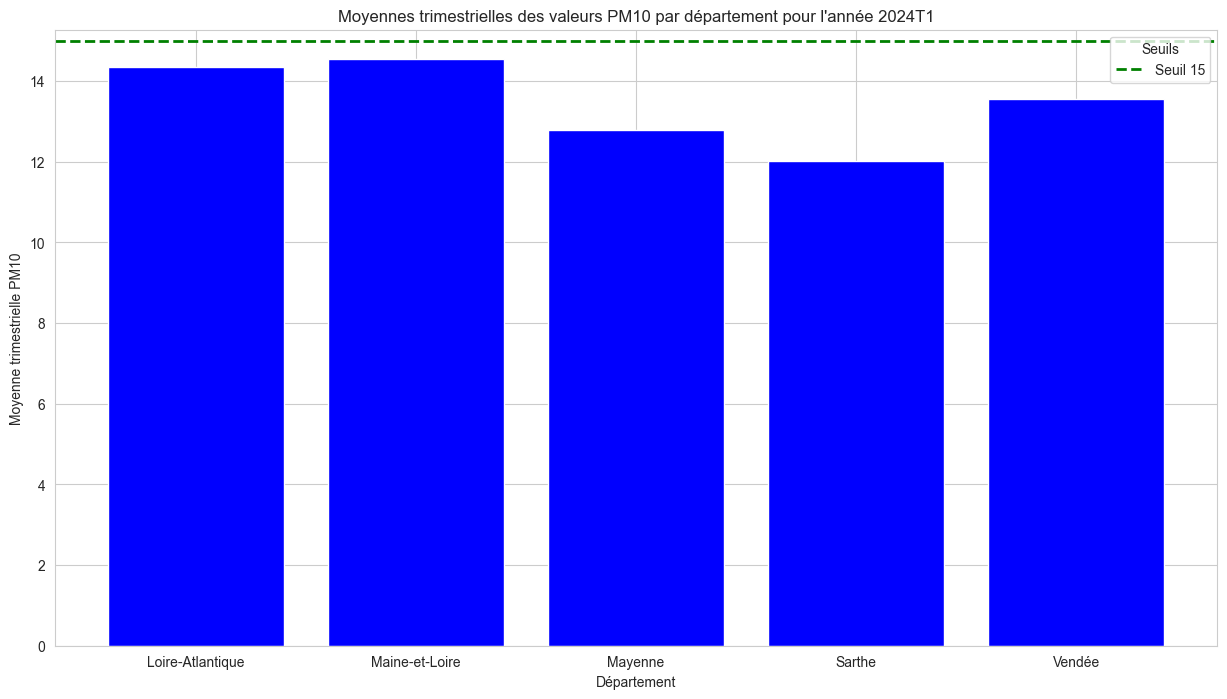

In [35]:
# Convertir les colonnes de date en format datetime si ce n'est pas déjà fait
dfPM10['date_heure_tu'] = pd.to_datetime(dfPM10['date_heure_tu'])

# Supprimer le fuseau horaire avant la conversion en périodes trimestrielles
dfPM10['date_heure_tu'] = dfPM10['date_heure_tu'].dt.tz_localize(None)

# Ajouter les colonnes 'année' et 'trimestre'
dfPM10['année'] = dfPM10['date_heure_tu'].dt.year
dfPM10['trimestre'] = dfPM10['date_heure_tu'].dt.to_period('Q').astype(str).str.replace('Q', 'T')

# Calculer la moyenne trimestrielle de PM10 pour chaque département et chaque année
quarterly_means = dfPM10.groupby(['année', 'trimestre', 'departement_nom'])['valeur'].mean().reset_index()

# Ajouter une colonne indiquant si la moyenne trimestrielle dépasse le seuil
quarterly_means['depasse_seuil'] = (quarterly_means['valeur'] > OBJECTIF_QUALITE_PM10_MENSUEL)

# Créer la palette de couleurs
quarterly_means['color'] = ['red' if x else 'blue' for x in quarterly_means['depasse_seuil']]

# Créer un graphique en bâtons pour chaque année et trimestre
years = quarterly_means['année'].unique()

for year in years:
    annual_data = quarterly_means[quarterly_means['année'] == year]
    trimesters = annual_data['trimestre'].unique()

    for quarter in trimesters:
        plt.figure(figsize=(15, 8))
        quarterly_data = annual_data[annual_data['trimestre'] == quarter]
        colors = quarterly_data['color']
        plt.bar(quarterly_data['departement_nom'], quarterly_data['valeur'], color=colors)

        # Ajouter des lignes horizontales pour les seuils
        plt.axhline(y=OBJECTIF_QUALITE_PM10_MENSUEL, color='green', linestyle='--', linewidth=2, label=f'Seuil {OBJECTIF_QUALITE_PM10_MENSUEL}')

        plt.xlabel('Département')
        plt.ylabel('Moyenne trimestrielle PM10')
        plt.title(f'Moyennes trimestrielles des valeurs PM10 par département pour l\'année {quarter}')
        plt.legend(title='Seuils')
        plt.xticks(rotation=0)  # Rotation pour mieux afficher les noms des départements
        plt.show()


#### Graphique pour voir trimestriel par département, par ville quand est-ce qu'on à dépassé le seuil de cible_objectif_qualité_PM10_mensuel


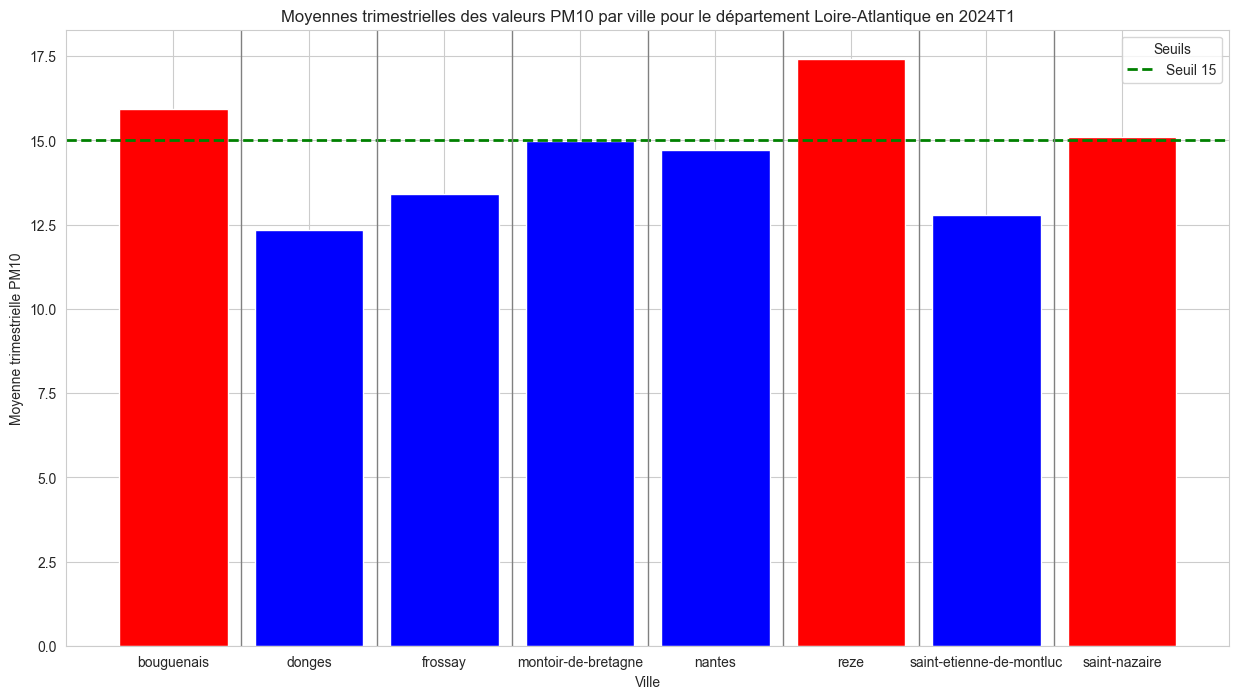

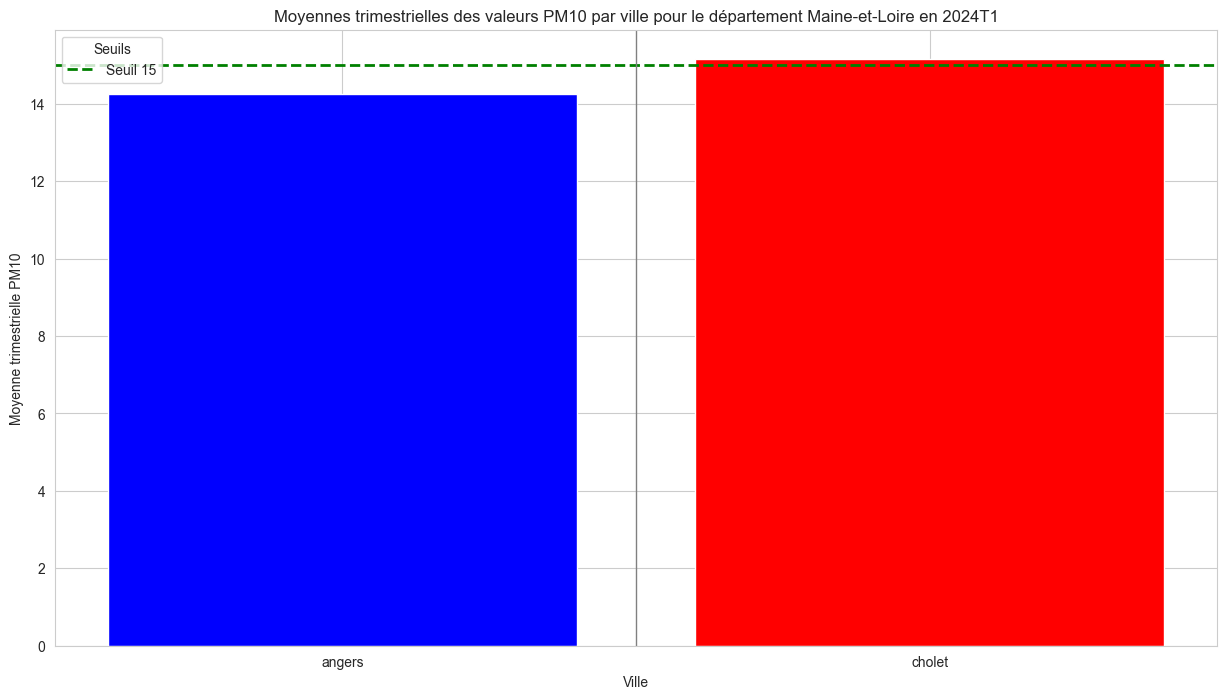

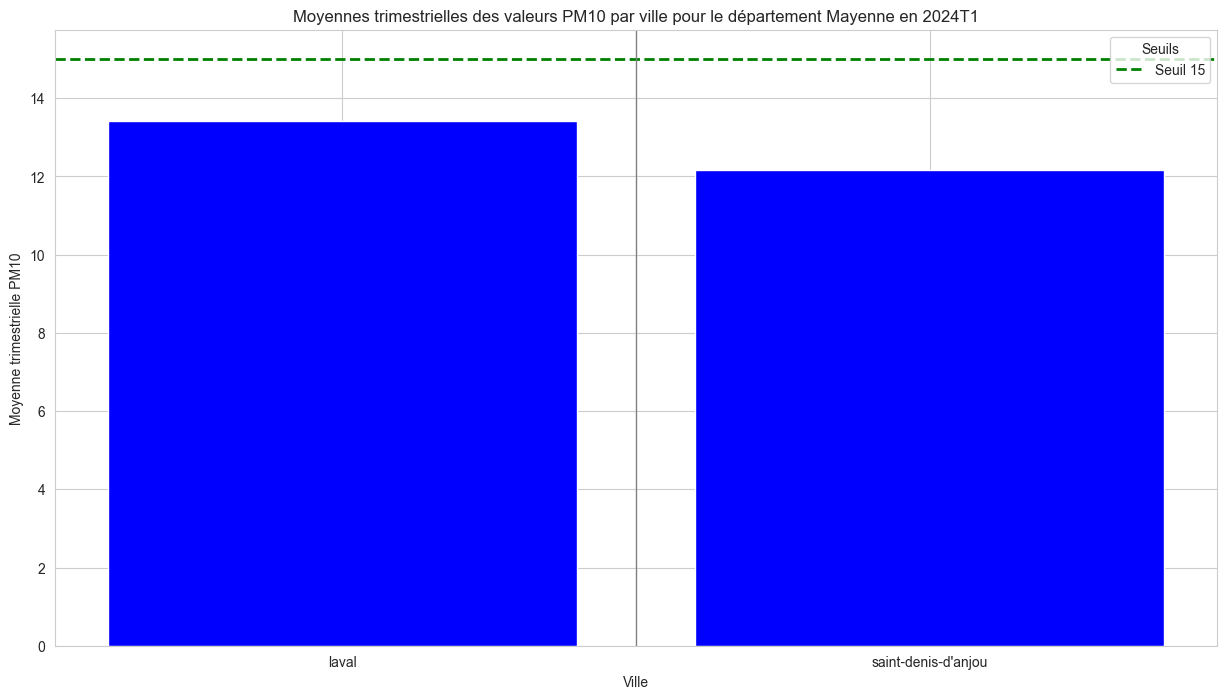

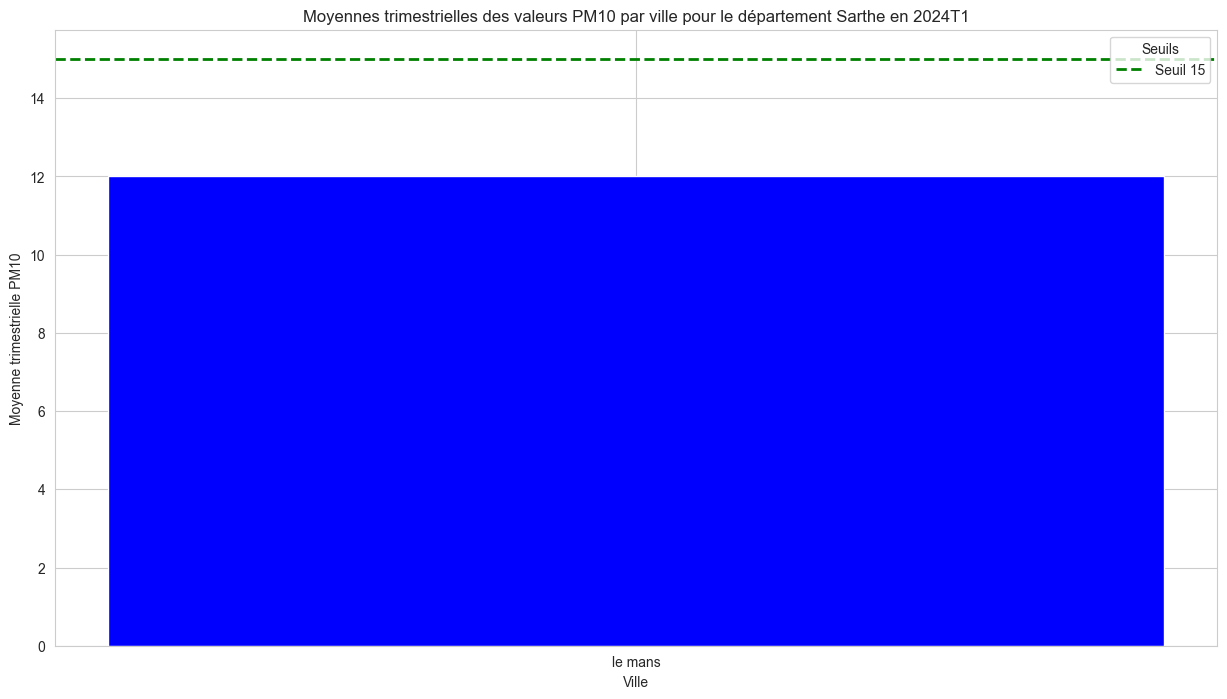

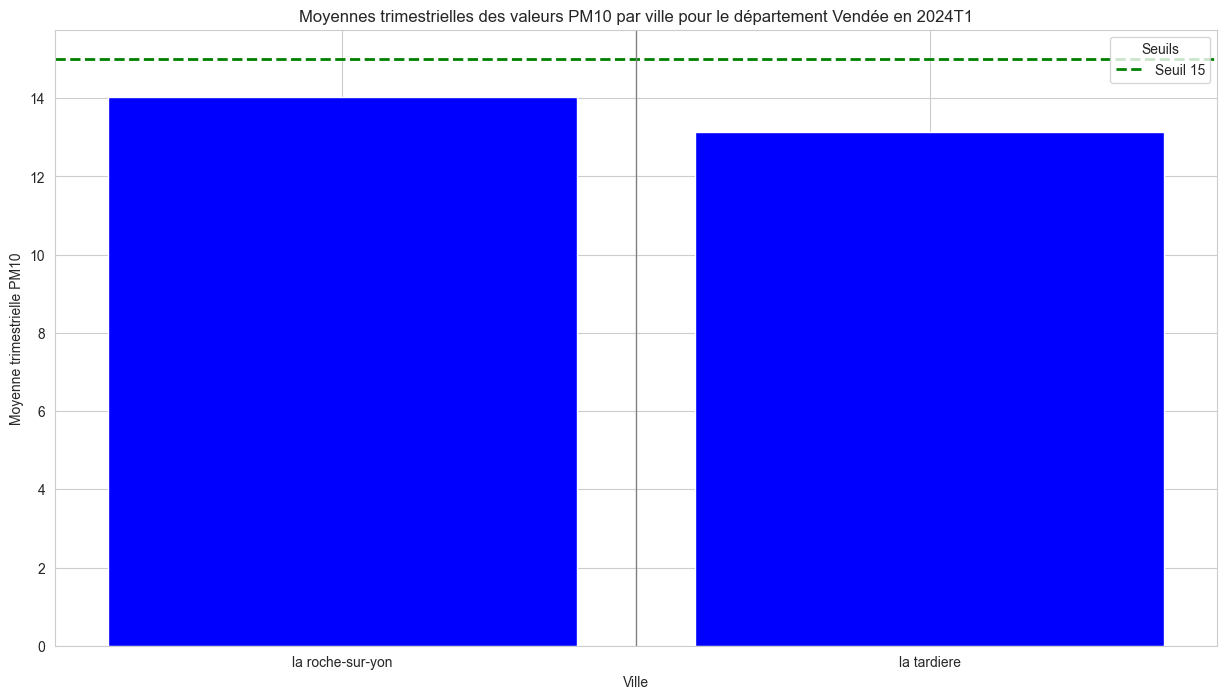

In [36]:
# Convertir les colonnes de date en format datetime si ce n'est pas déjà fait
dfPM10['date_heure_tu'] = pd.to_datetime(dfPM10['date_heure_tu'])

# Supprimer le fuseau horaire avant la conversion en périodes trimestrielles
dfPM10['date_heure_tu'] = dfPM10['date_heure_tu'].dt.tz_localize(None)

# Ajouter les colonnes 'année' et 'trimestre'
dfPM10['année'] = dfPM10['date_heure_tu'].dt.year
dfPM10['trimestre'] = dfPM10['date_heure_tu'].dt.to_period('Q').astype(str).str.replace('Q', 'T')

# Calculer la moyenne trimestrielle de PM10 pour chaque département, chaque ville et chaque année
quarterly_means = dfPM10.groupby(['année', 'trimestre', 'departement_nom', 'nom_commune'])['valeur'].mean().reset_index()

# Ajouter une colonne indiquant si la moyenne trimestrielle dépasse les seuils
quarterly_means['depasse_seuil'] = (quarterly_means['valeur'] > OBJECTIF_QUALITE_PM10_MENSUEL)

# Créer la palette de couleurs
quarterly_means['color'] = ['red' if x else 'blue' for x in quarterly_means['depasse_seuil']]

# Créer un graphique en bâtons pour chaque année et chaque département
years = quarterly_means['année'].unique()
departments = quarterly_means['departement_nom'].unique()

for year in years:
    for department in departments:
        annual_dept_data = quarterly_means[(quarterly_means['année'] == year) & (quarterly_means['departement_nom'] == department)]
        
        if not annual_dept_data.empty:
            for quarter in annual_dept_data['trimestre'].unique():
                plt.figure(figsize=(15, 8))
                quarterly_data = annual_dept_data[annual_dept_data['trimestre'] == quarter]
                colors = quarterly_data['color']
                plt.bar(quarterly_data['nom_commune'], quarterly_data['valeur'], color=colors)

                # Ajouter des lignes horizontales pour les seuils
                plt.axhline(y=OBJECTIF_QUALITE_PM10_MENSUEL, color='green', linestyle='--', linewidth=2, label=f'Seuil {OBJECTIF_QUALITE_PM10_MENSUEL}')

                # Ajouter des lignes verticales pour séparer les trimestres
                for i in range(1, len(quarterly_data['nom_commune'])):
                    plt.axvline(x=i - 0.5, color='grey', linestyle='-', linewidth=1)

                plt.xlabel('Ville')
                plt.ylabel('Moyenne trimestrielle PM10')
                plt.title(f'Moyennes trimestrielles des valeurs PM10 par ville pour le département {department} en {quarter}')
                plt.legend(title='Seuils')
                plt.xticks(rotation=0)  # Rotation pour mieux afficher les noms des villes
                plt.show()


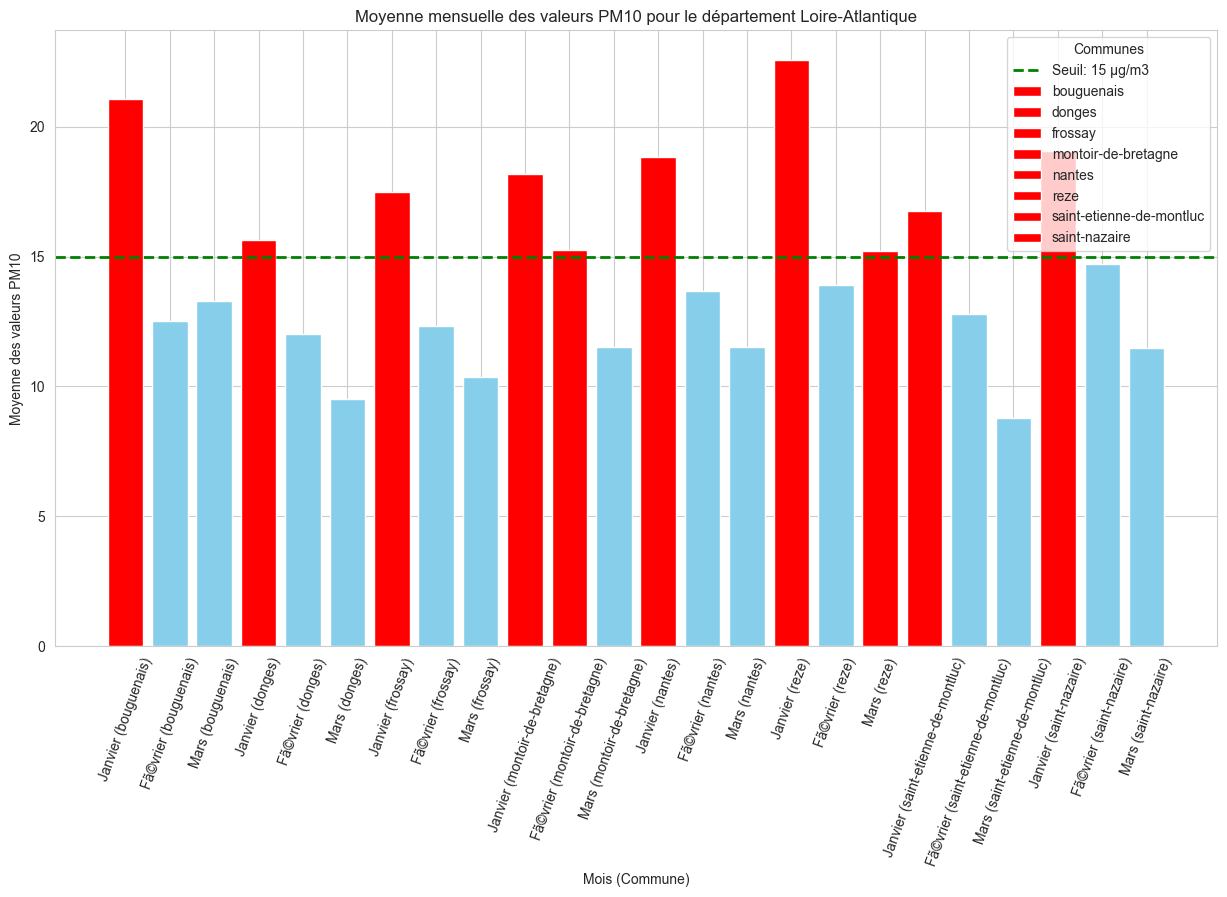

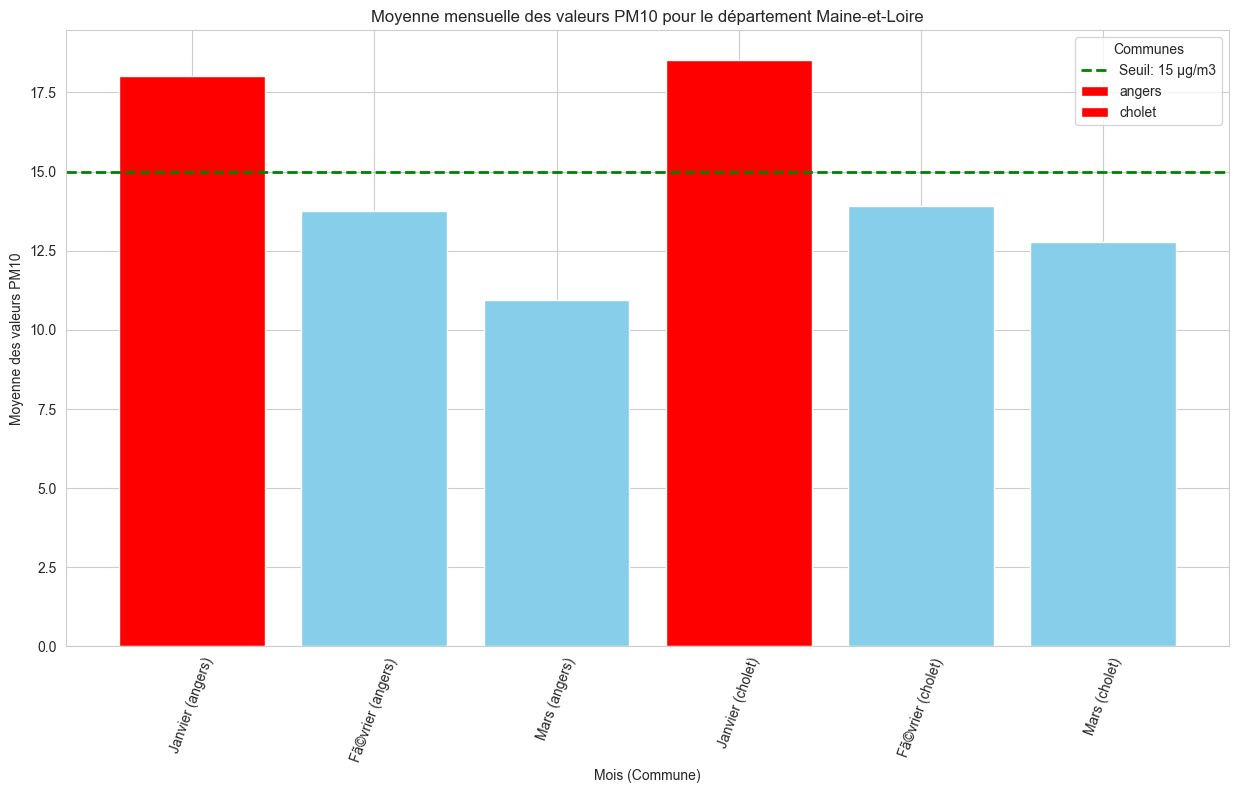

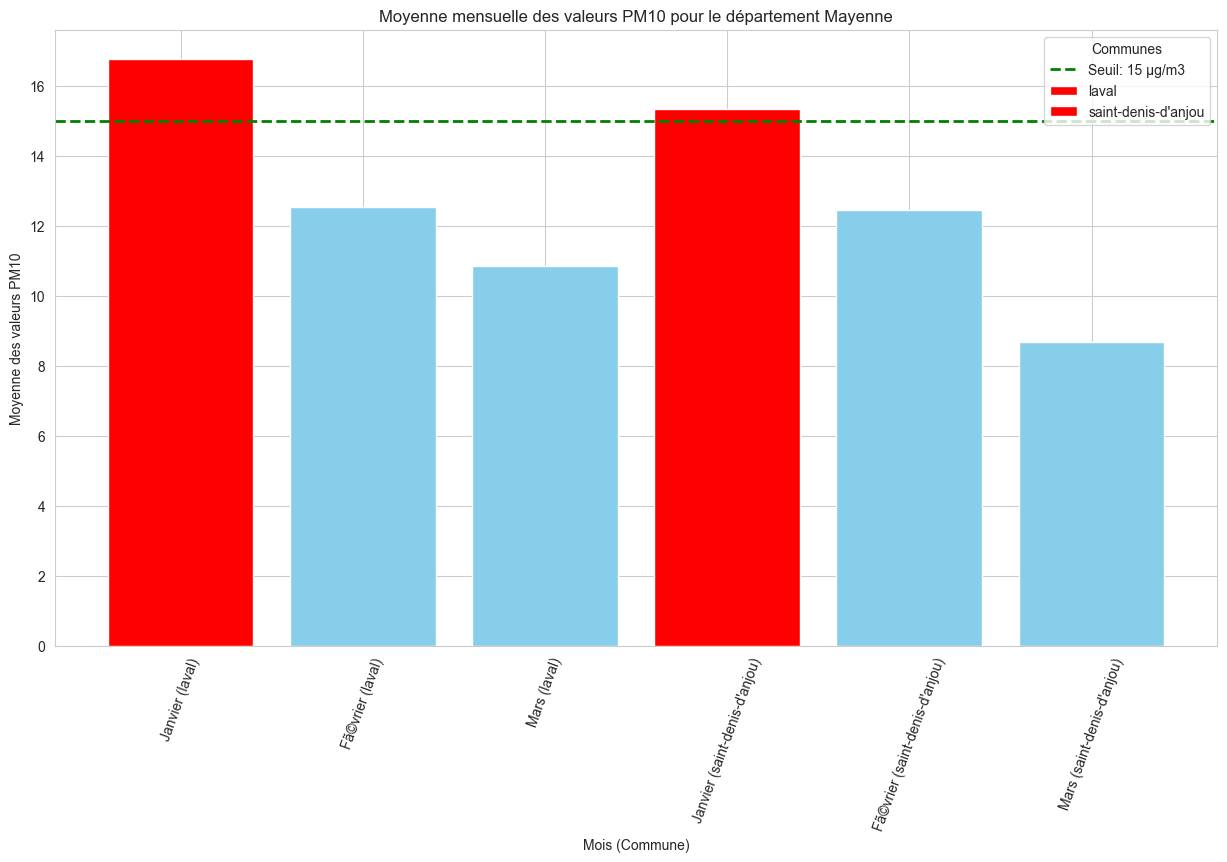

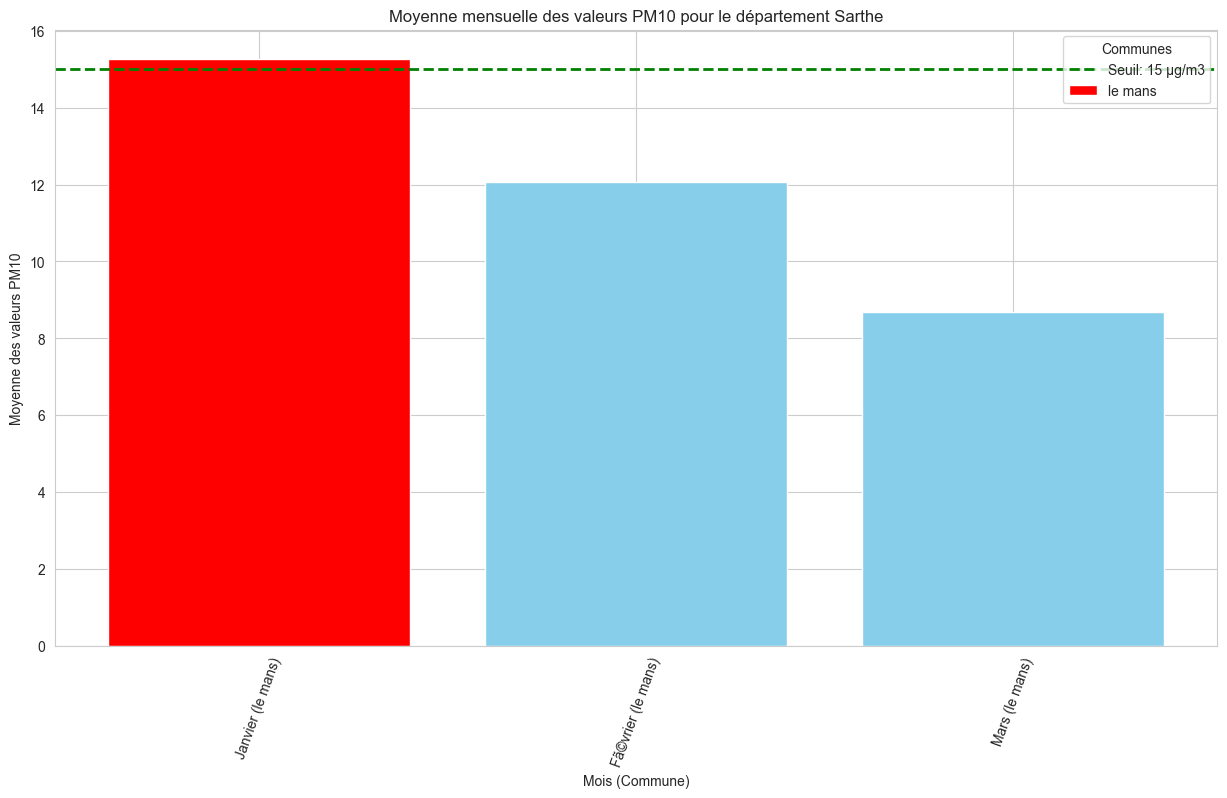

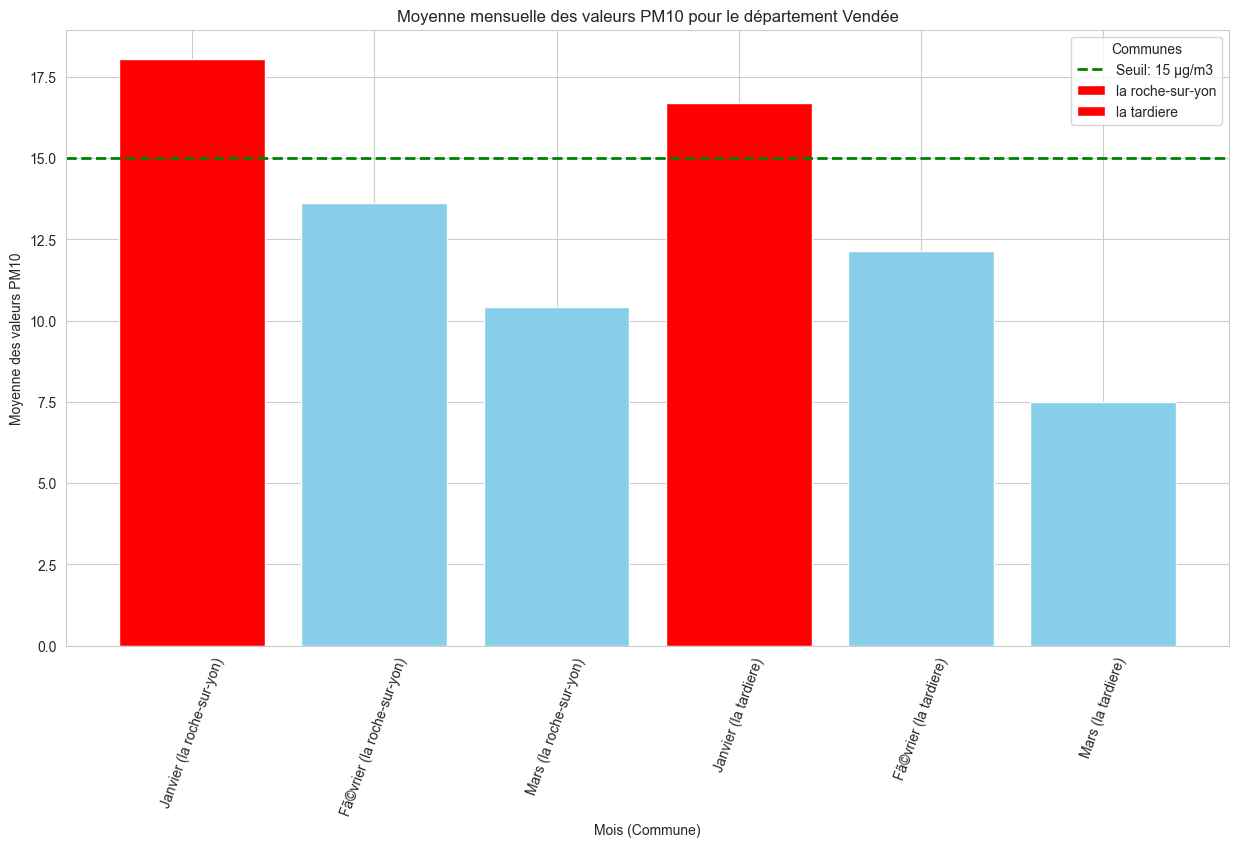

In [38]:
import locale
import calendar

# Définir la locale en français
locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')

# Ajouter la colonne 'mois' pour grouper par mois
dfPM10['mois'] = dfPM10['date_heure_tu'].dt.month

# Calculer la moyenne mensuelle des valeurs de PM10 pour chaque département et chaque commune
monthly_means = dfPM10.groupby(['departement_nom', 'nom_commune', 'mois'])['valeur'].mean().reset_index()

# Convertir les numéros des mois en noms de mois
monthly_means['mois_lettres'] = monthly_means['mois'].apply(lambda x: calendar.month_name[x].capitalize())

# Ajouter une colonne indiquant si la moyenne mensuelle dépasse le seuil
monthly_means['depasse_seuil'] = monthly_means['valeur'] > OBJECTIF_QUALITE_PM10_MENSUEL

# Obtenir la liste des départements uniques
departments = monthly_means['departement_nom'].unique()

# Créer un graphique en barres pour chaque département regroupant les communes
for department in departments:
    dept_data = monthly_means[monthly_means['departement_nom'] == department]
    
    plt.figure(figsize=(15, 8))
    
    # Grouper les communes dans le département
    communes = dept_data['nom_commune'].unique()
    for commune in communes:
        commune_data = dept_data[dept_data['nom_commune'] == commune]
        colors = commune_data['depasse_seuil'].map({True: 'red', False: 'skyblue'})
        bars = plt.bar(commune_data['mois_lettres'] + " (" + commune + ")", commune_data['valeur'], color=colors, label=commune)
    
    # Ajouter une ligne horizontale pour le seuil OBJECTIF_QUALITE_PM10_MENSUEL
    plt.axhline(y=OBJECTIF_QUALITE_PM10_MENSUEL, color='green', linestyle='--', linewidth=2, label=f'Seuil: {OBJECTIF_QUALITE_PM10_MENSUEL} µg/m3')
    
    plt.xlabel('Mois (Commune)')
    plt.ylabel('Moyenne des valeurs PM10')
    plt.title(f'Moyenne mensuelle des valeurs PM10 pour le département {department}')
    plt.legend(title='Communes')
    plt.xticks(rotation=70)  # Rotation pour mieux afficher les noms des communes et des mois
    plt.show()


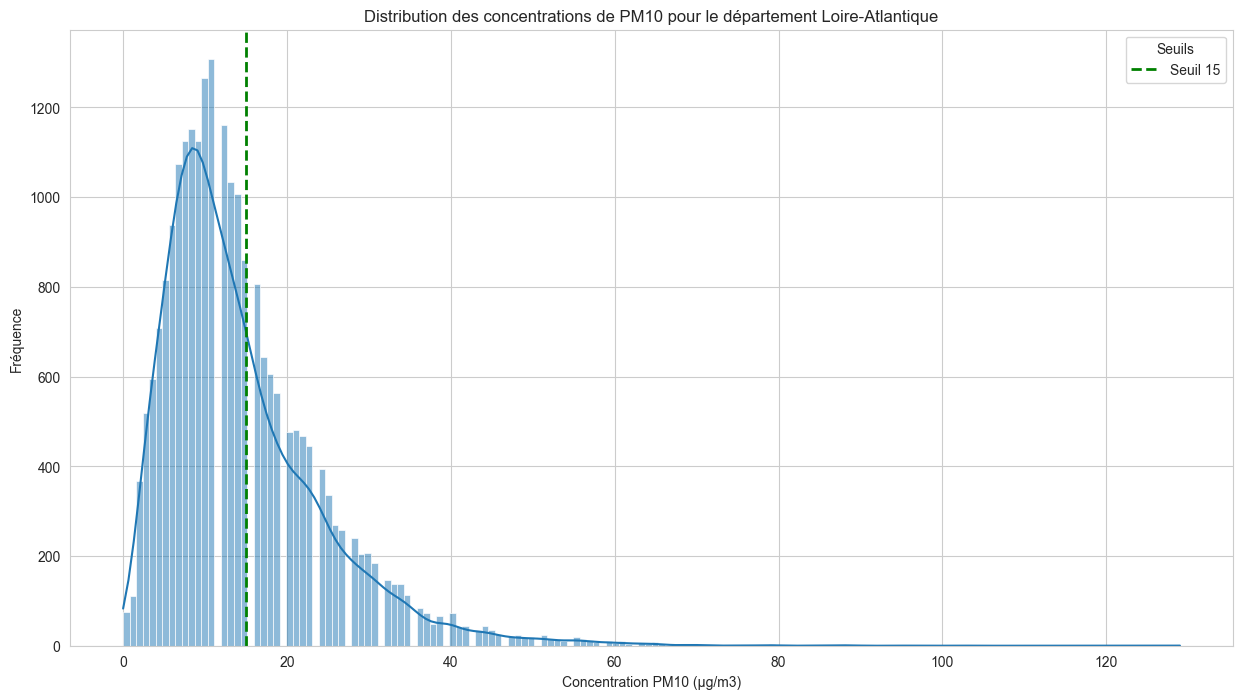

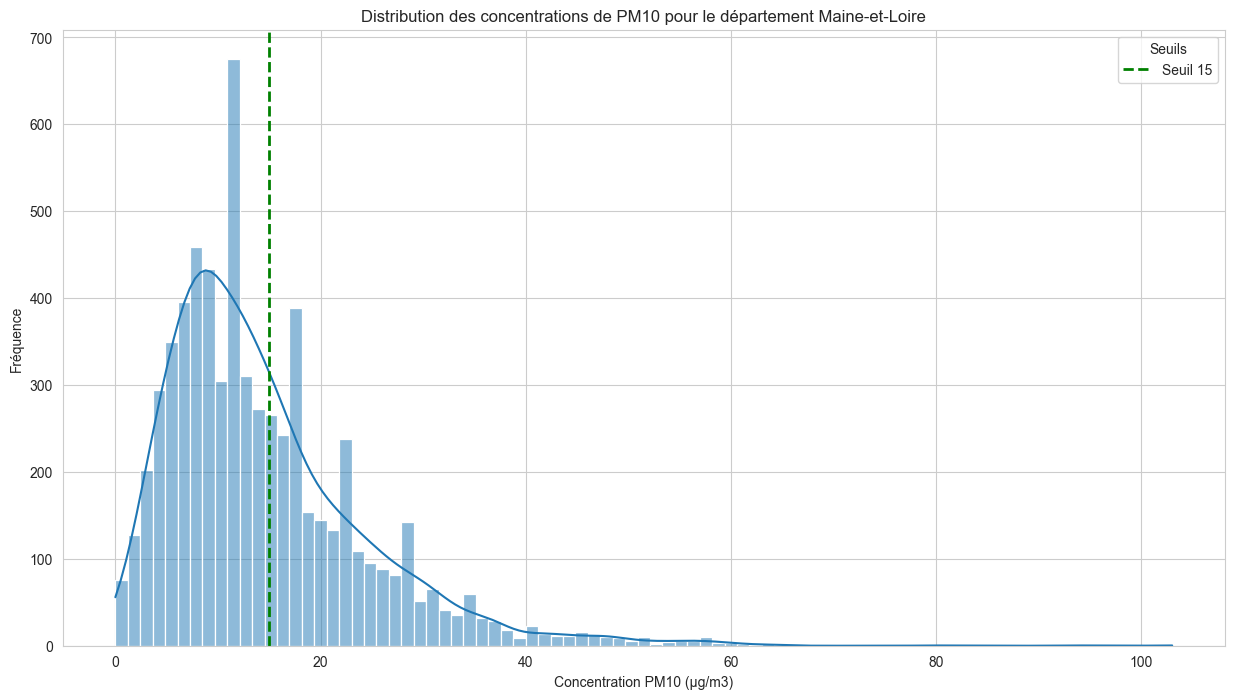

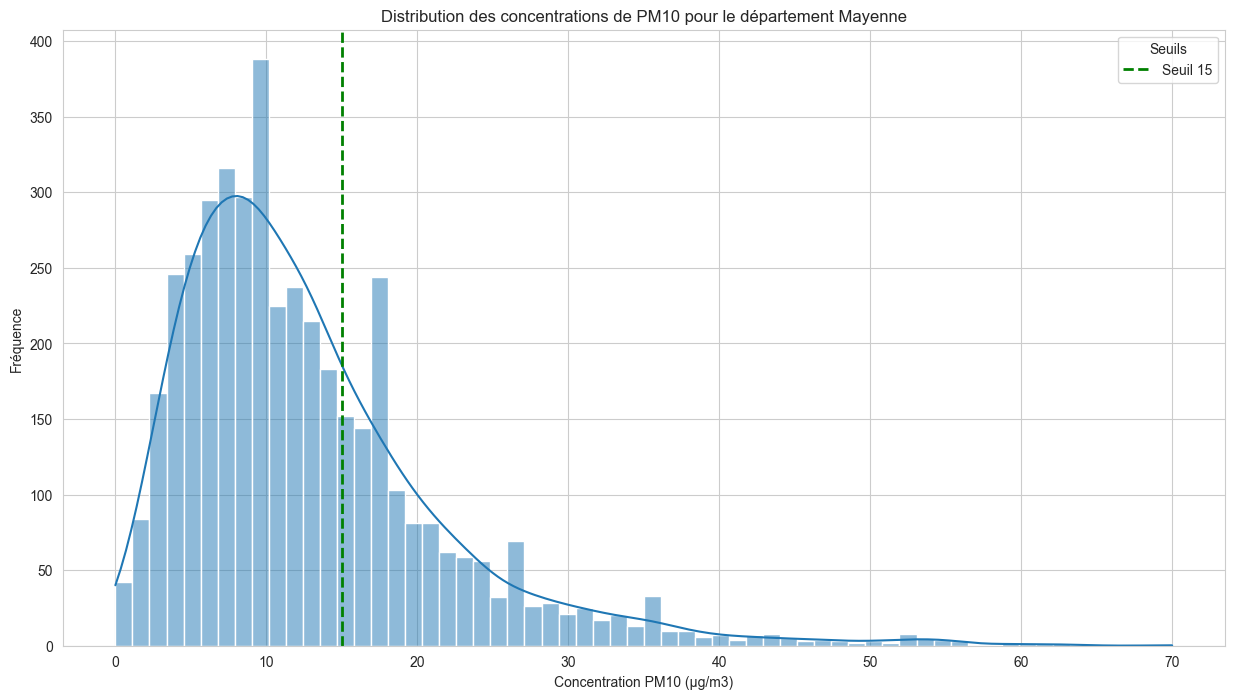

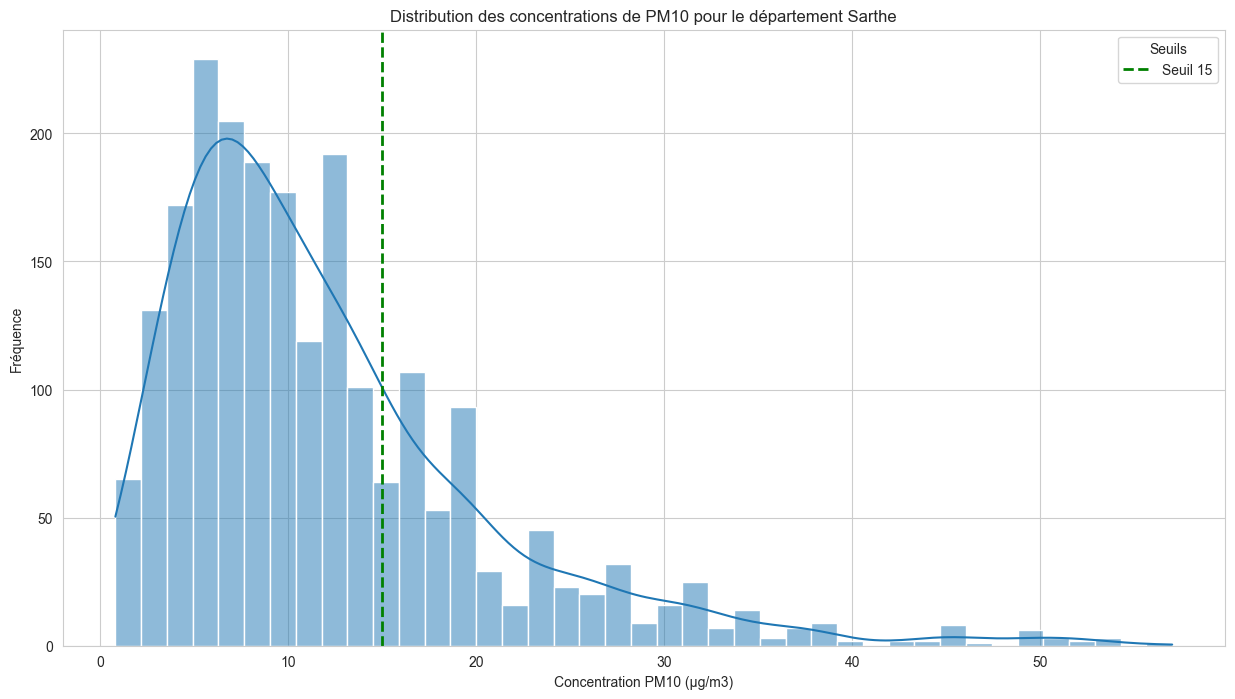

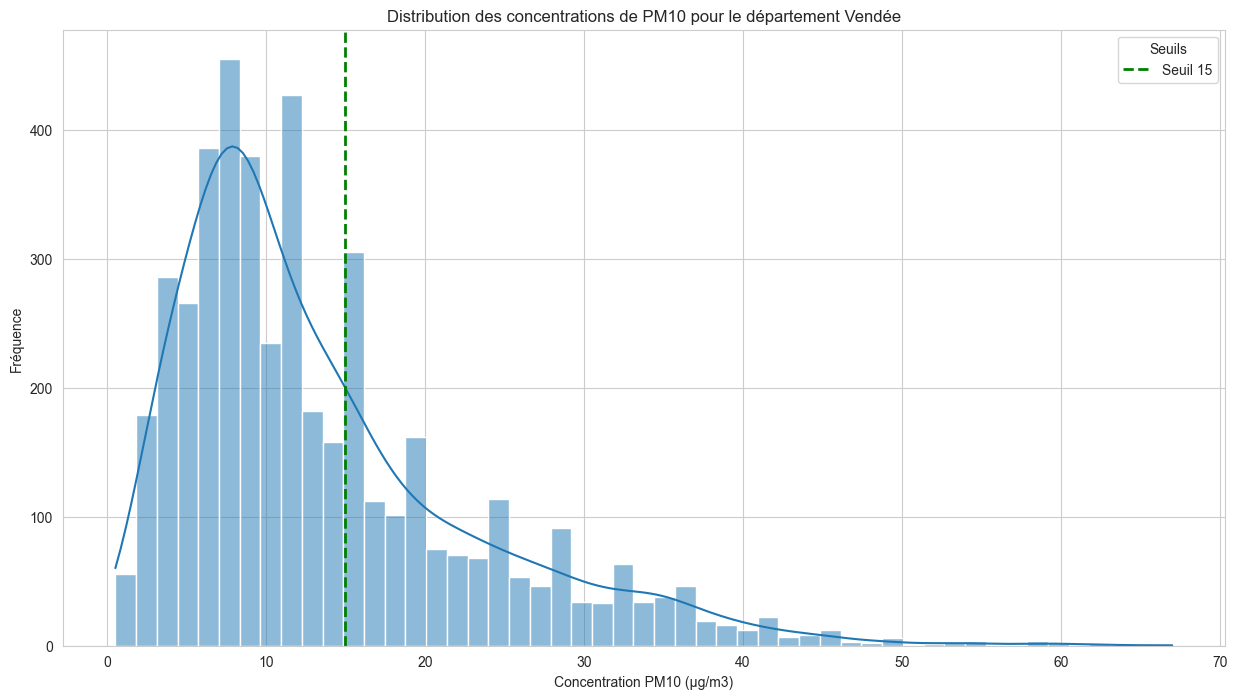

In [13]:
# Créer un histogramme pour chaque département
for department in departments:
    plt.figure(figsize=(15, 8))
    dept_data = dfPM10[dfPM10['departement_nom'] == department]
    
    sns.histplot(dept_data['valeur'], kde=True)
    
    plt.axvline(x=OBJECTIF_QUALITE_PM10_MENSUEL, color='green', linestyle='--', linewidth=2, label=f'Seuil {OBJECTIF_QUALITE_PM10_MENSUEL}')
    
    plt.xlabel('Concentration PM10 (µg/m3)')
    plt.ylabel('Fréquence')
    plt.title(f'Distribution des concentrations de PM10 pour le département {department}')
    plt.legend(title='Seuils')
    plt.show()


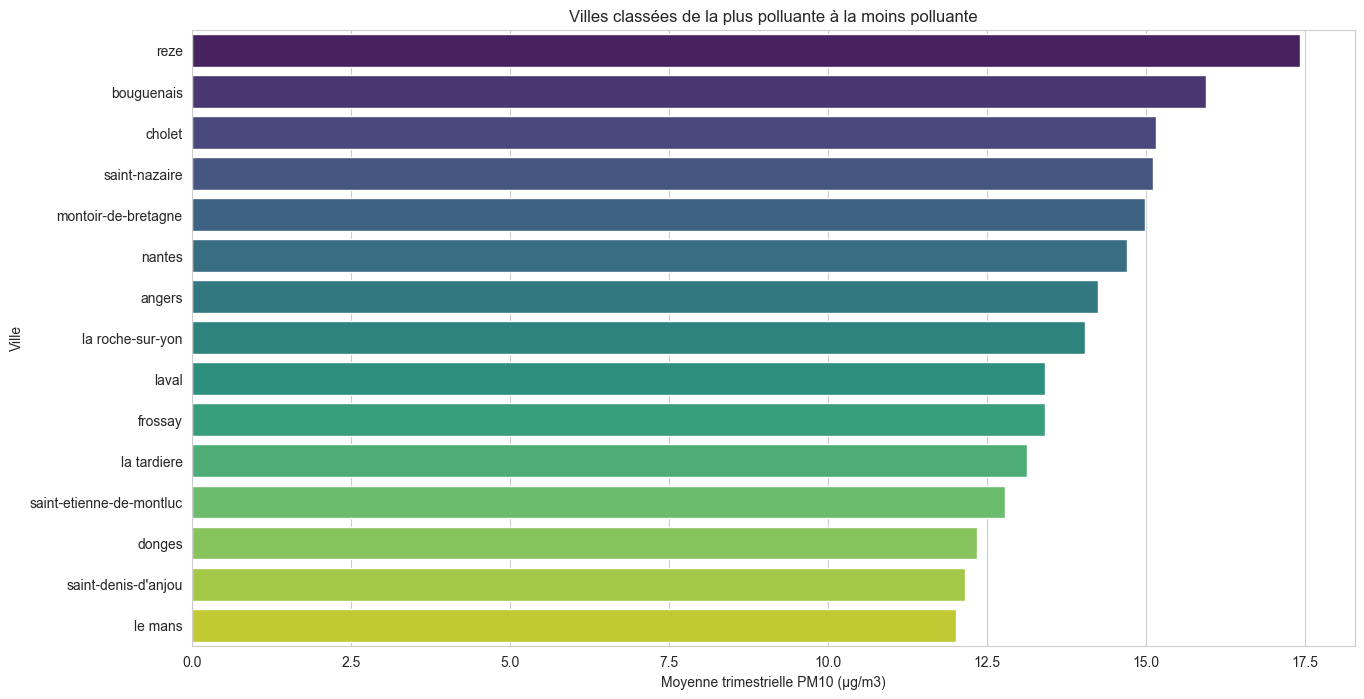

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculer la moyenne annuelle de PM10 pour chaque ville
city_means = dfPM10.groupby('nom_commune')['valeur'].mean().reset_index()

# Trier les villes de la plus polluante à la moins polluante
city_means = city_means.sort_values(by='valeur', ascending=False)

# Créer un graphique en bâtons pour les villes
plt.figure(figsize=(15, 8))
sns.barplot(data=city_means, x='valeur', y='nom_commune', hue='nom_commune', dodge=False, palette='viridis', legend=False)

plt.xlabel('Moyenne trimestrielle PM10 (µg/m3)')
plt.ylabel('Ville')
plt.title('Villes classées de la plus polluante à la moins polluante')
plt.show()


### les valeurs pour le premier trimestre 2024 dépassent le seuil d'information et de recommandation (SEUIL_INFO_RECO),

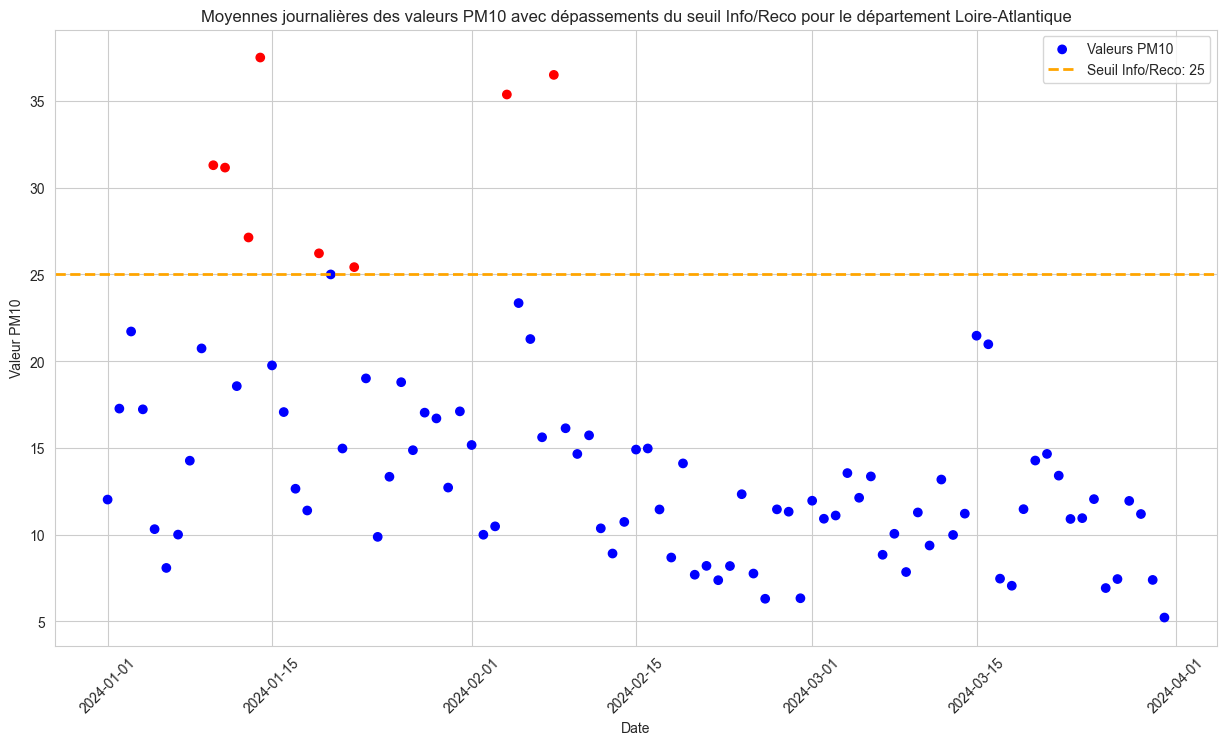

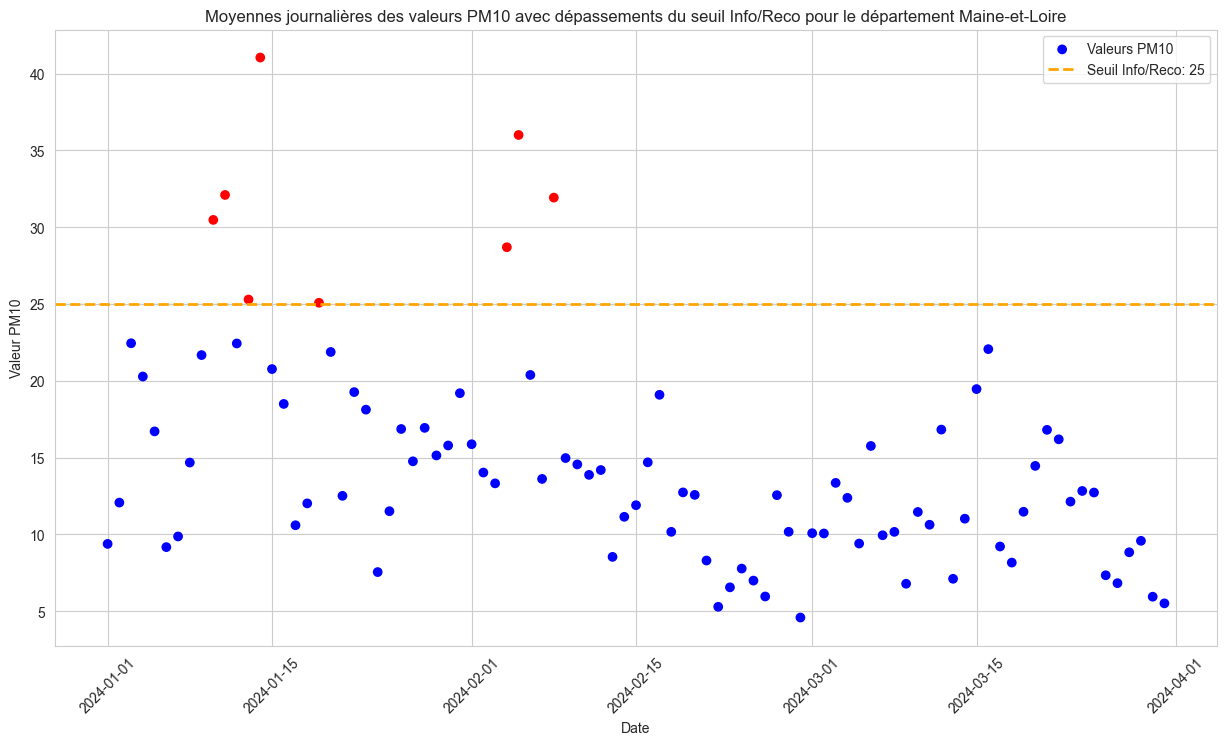

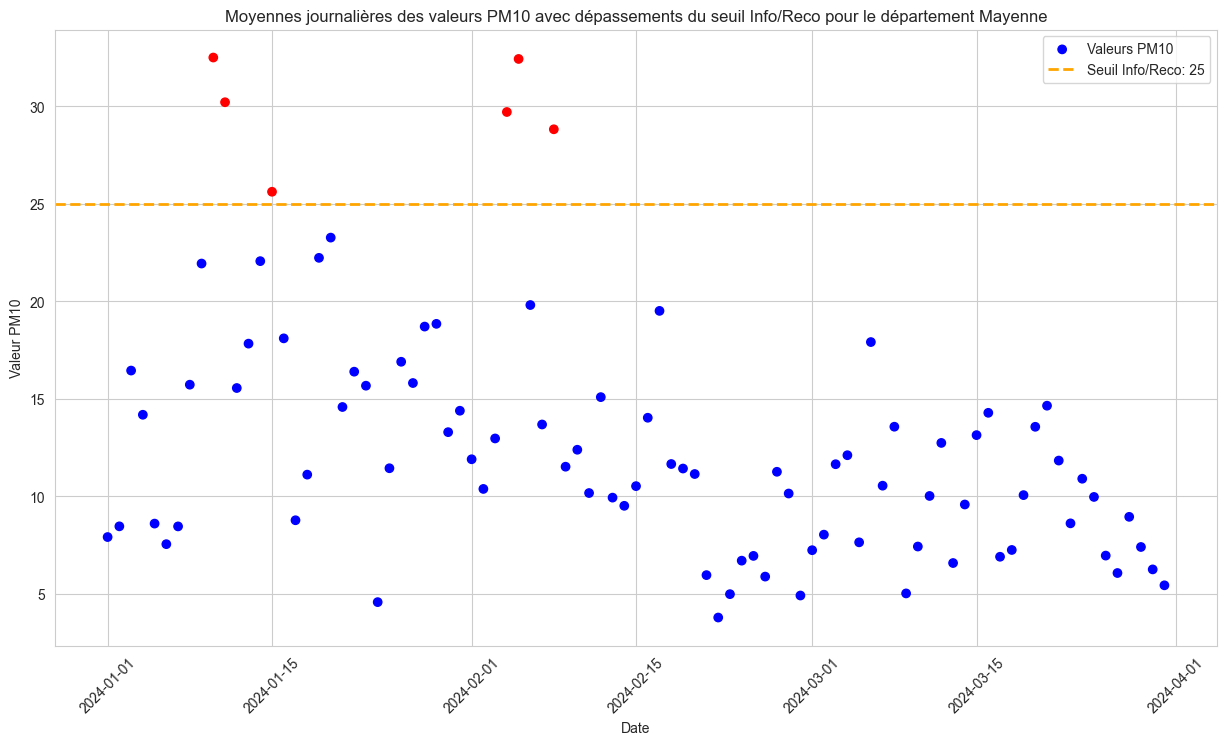

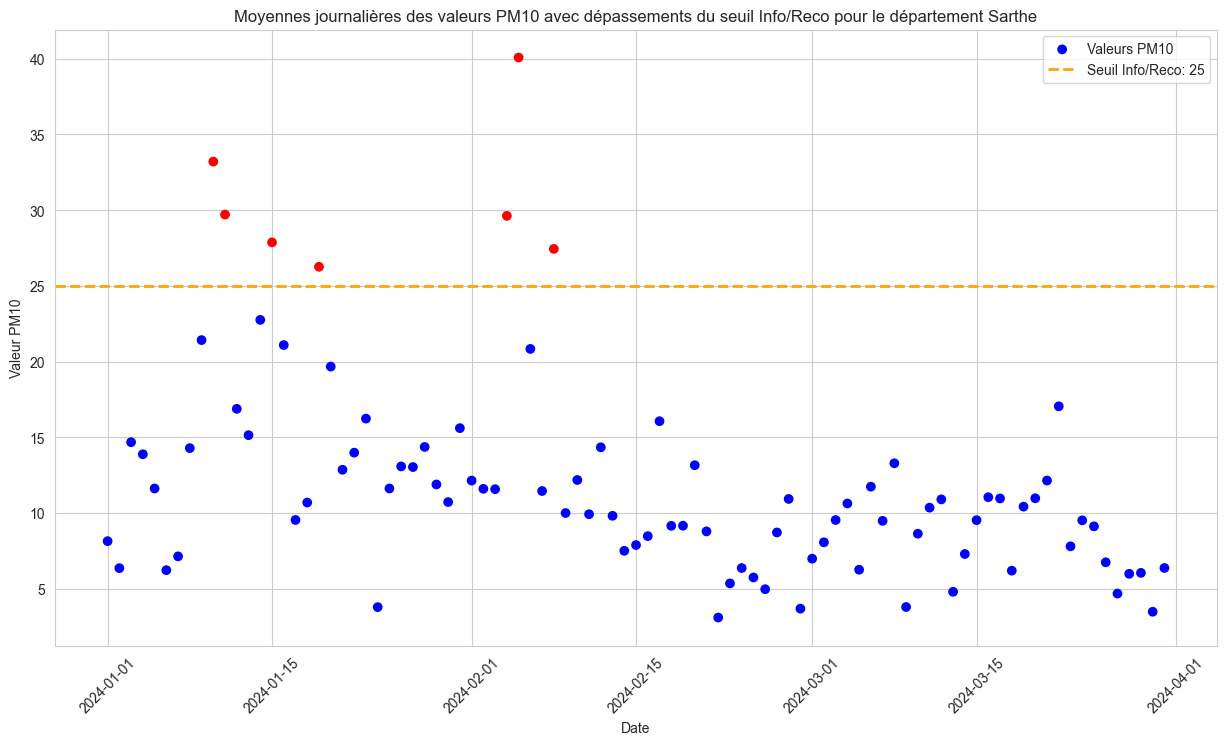

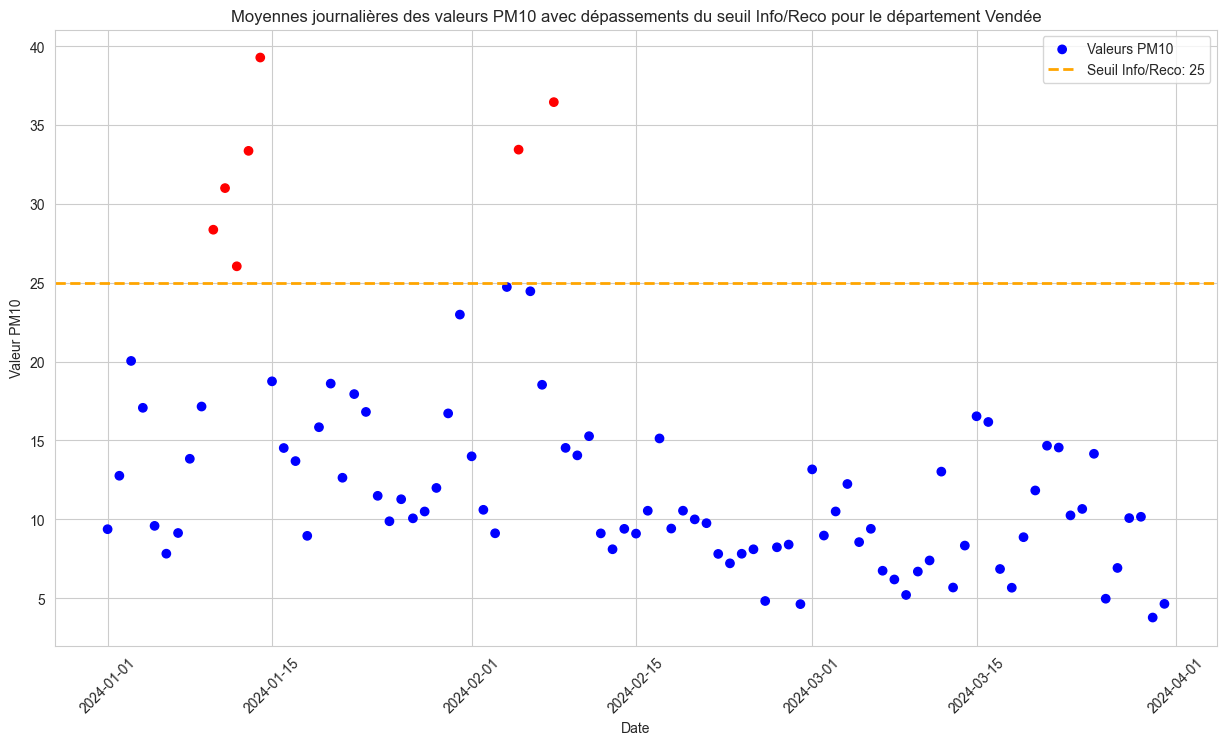

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir les colonnes de date en format datetime si ce n'est pas déjà fait
dfPM10['date_heure_tu'] = pd.to_datetime(dfPM10['date_heure_tu'])

# Ajouter la colonne 'jour' pour grouper par jour
dfPM10['jour'] = dfPM10['date_heure_tu'].dt.date

# Calculer la moyenne journalière des valeurs de PM10 par département
daily_means = dfPM10.groupby(['jour', 'departement_nom'])['valeur'].mean().reset_index()

# Ajouter une colonne indiquant si la moyenne journalière dépasse le seuil d'information et de recommandation
daily_means['depasse_seuil_info_reco'] = daily_means['valeur'] > SEUIL_INFO_RECO

# Obtenir la liste des départements uniques
departments = daily_means['departement_nom'].unique()

# Créer un graphique pour chaque département
for department in departments:
    dept_data = daily_means[daily_means['departement_nom'] == department]
    
    plt.figure(figsize=(15, 8))
    
    # Tracer les valeurs avec une couleur différente pour celles qui dépassent le seuil
    colors = ['red' if x else 'blue' for x in dept_data['depasse_seuil_info_reco']]
    plt.scatter(dept_data['jour'], dept_data['valeur'], c=colors, label='Valeurs PM10')
    
    # Ajouter des lignes horizontales pour les seuils
    plt.axhline(y=SEUIL_INFO_RECO, color='orange', linestyle='--', linewidth=2, label=f'Seuil Info/Reco: {SEUIL_INFO_RECO}')
    
    plt.xlabel('Date')
    plt.ylabel('Valeur PM10')
    plt.title(f'Moyennes journalières des valeurs PM10 avec dépassements du seuil Info/Reco pour le département {department}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()


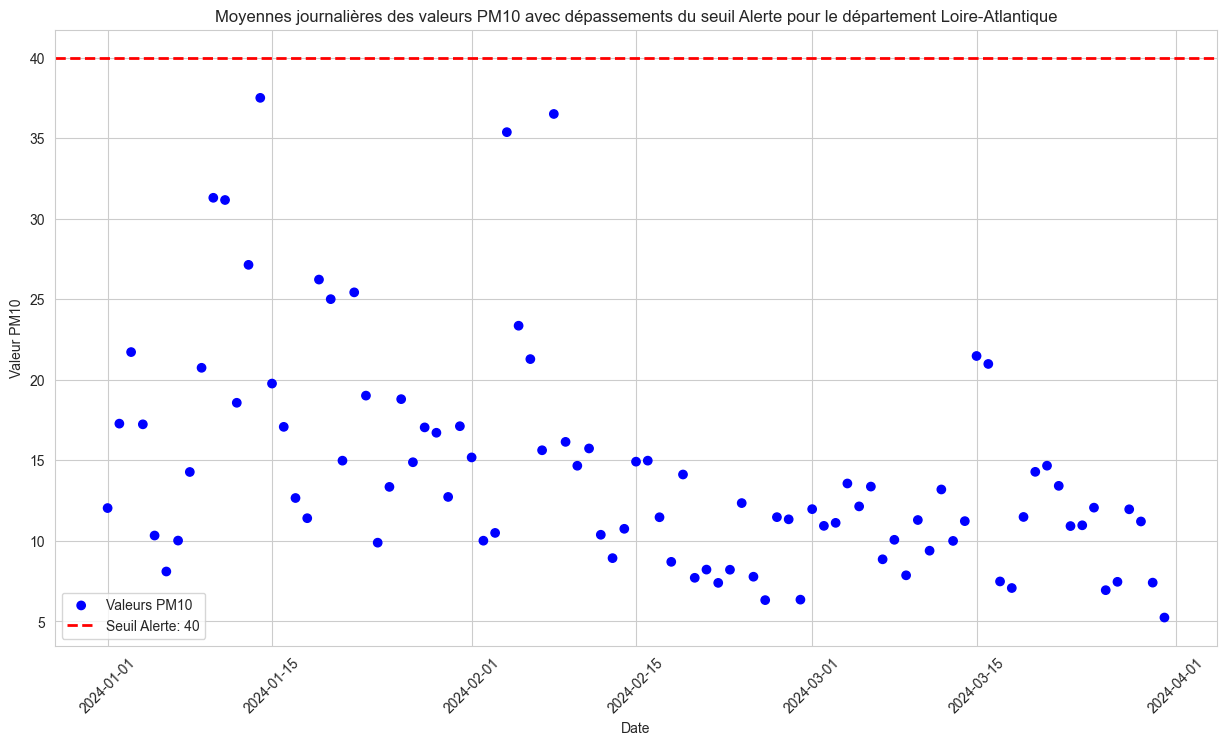

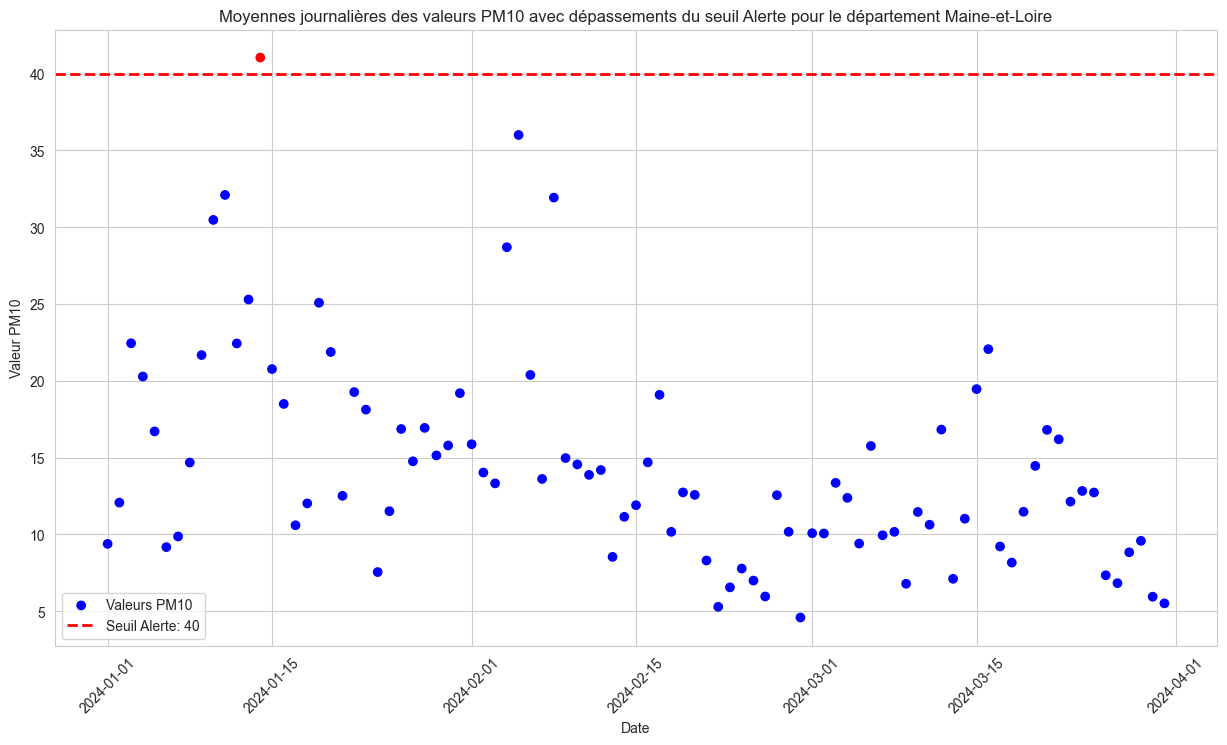

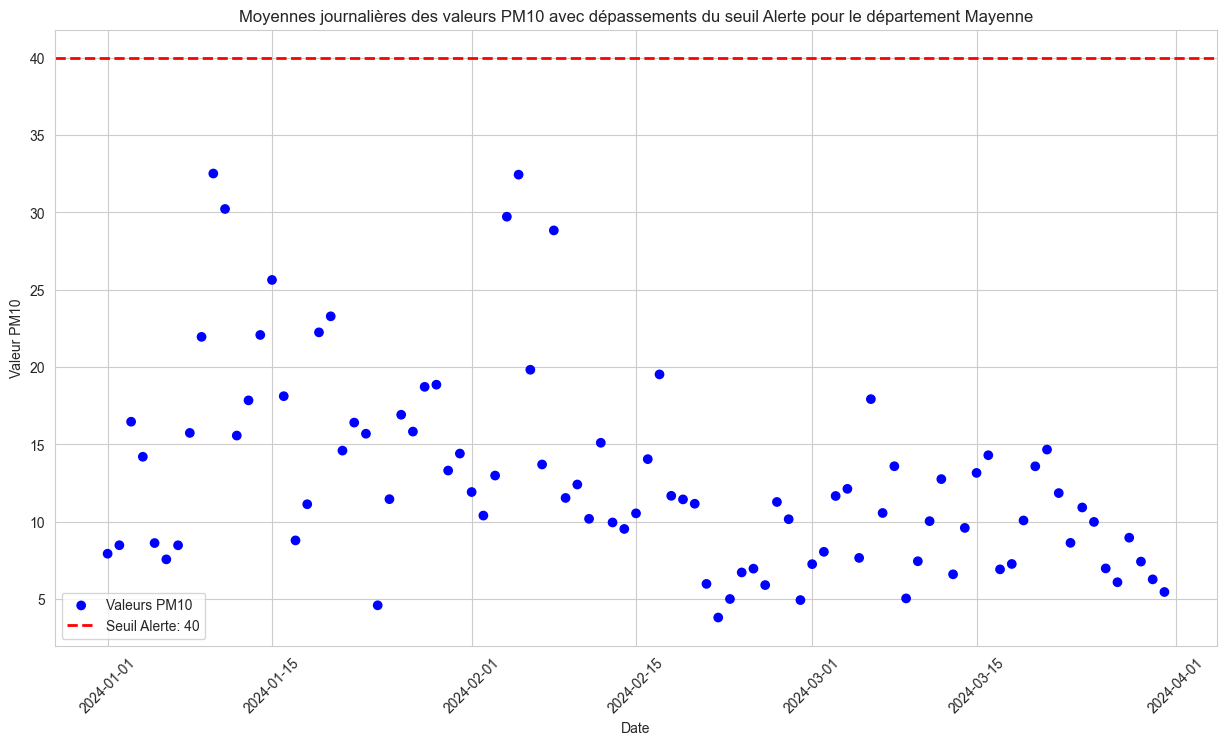

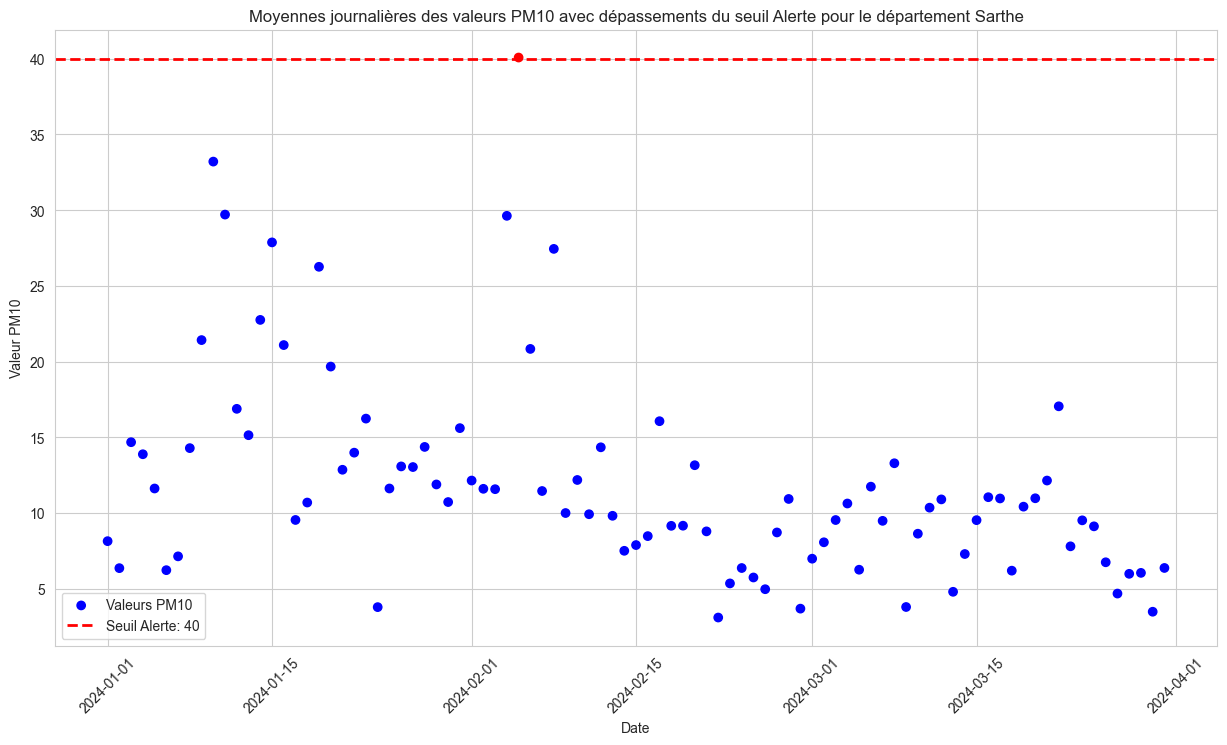

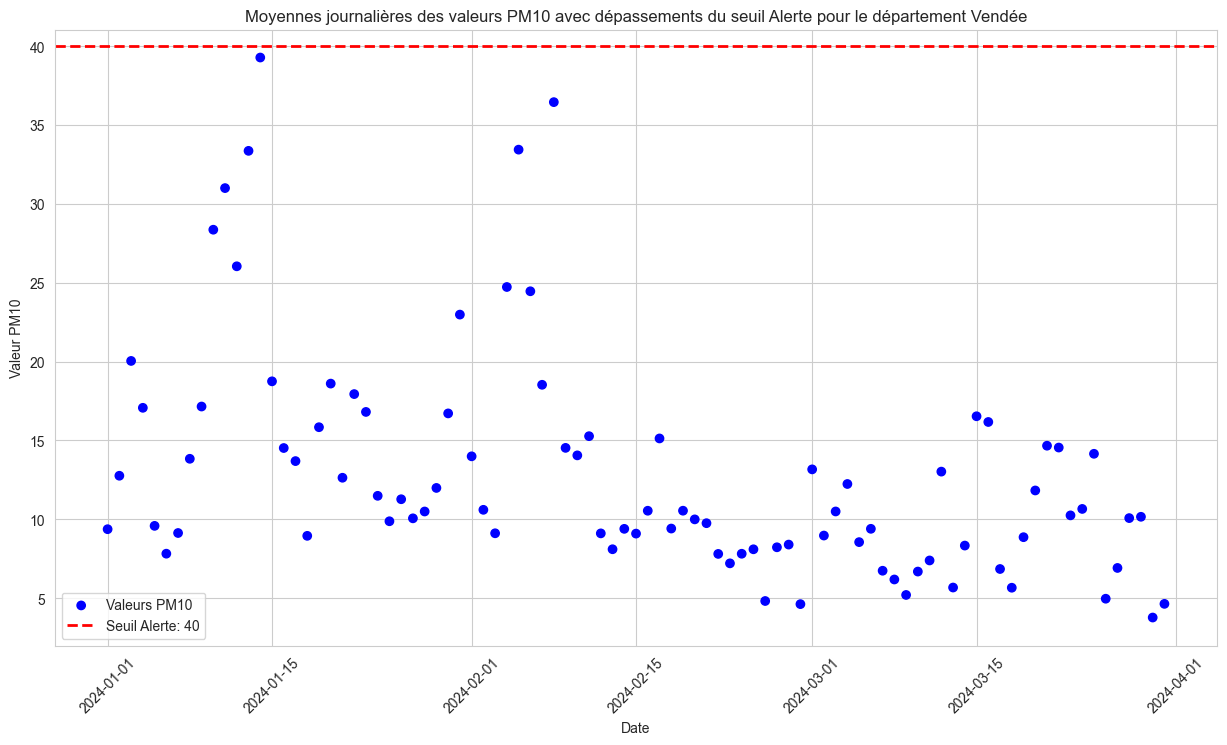

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir les colonnes de date en format datetime si ce n'est pas déjà fait
dfPM10['date_heure_tu'] = pd.to_datetime(dfPM10['date_heure_tu'])

# Ajouter la colonne 'jour' pour grouper par jour
dfPM10['jour'] = dfPM10['date_heure_tu'].dt.date

# Calculer la moyenne journalière des valeurs de PM10 par département
daily_means = dfPM10.groupby(['jour', 'departement_nom'])['valeur'].mean().reset_index()

# Ajouter une colonne indiquant si la moyenne journalière dépasse le seuil d'alerte
daily_means['depasse_seuil_alerte'] = daily_means['valeur'] > SEUIL_ALERTE

# Obtenir la liste des départements uniques
departments = daily_means['departement_nom'].unique()

# Créer un graphique pour chaque département
for department in departments:
    dept_data = daily_means[daily_means['departement_nom'] == department]
    
    plt.figure(figsize=(15, 8))
    
    # Tracer les valeurs avec une couleur différente pour celles qui dépassent le seuil
    colors = ['red' if x else 'blue' for x in dept_data['depasse_seuil_alerte']]
    plt.scatter(dept_data['jour'], dept_data['valeur'], c=colors, label='Valeurs PM10')
    
    # Ajouter des lignes horizontales pour les seuils
    plt.axhline(y=SEUIL_ALERTE, color='red', linestyle='--', linewidth=2, label=f'Seuil Alerte: {SEUIL_ALERTE}')
    
    plt.xlabel('Date')
    plt.ylabel('Valeur PM10')
    plt.title(f'Moyennes journalières des valeurs PM10 avec dépassements du seuil Alerte pour le département {department}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()


## Fusion des données avec le jeu de données dfPopulation

In [17]:
import importlib
import population

# Recharger le module pour prendre en compte les modifications
importlib.reload(population)

# Importer la fonction depuis le fichier Python
from population import fetch_and_process_population_data

# Utilisation de la fonction importée
base_url = "https://data.paysdelaloire.fr/api/explore/v2.1/catalog/datasets/12002701600563_population_pays_de_la_loire_2019_communes_epci/records"
dfPopulation = fetch_and_process_population_data(base_url)

# Afficher les premières lignes du DataFrame dfPopulation pour vérifier les modifications
print(dfPopulation.head())

# Afficher les types de colonnes pour vérifier les conversions
print(dfPopulation.dtypes)



Total records retrieved: 1238
   code_region  nom_de_la_region  code_departement  code_arrondissement  \
0           52  Pays de la Loire                44                    3   
1           52  Pays de la Loire                44                    2   
2           52  Pays de la Loire                44                    3   
3           52  Pays de la Loire                44                    2   
4           52  Pays de la Loire                44                    3   

   code_canton  code_commune nom_de_la_commune  population_municipale  \
0            9         44006           asserac                 1790.0   
1           21         44018            bouaye                 7844.0   
2           89         44005   chaumes-en-retz                 6759.0   
3           24         44047           coueron                21372.0   
4            2         44049        le croisic                 4093.0   

   population_comptee_a_part  population_totale  \
0                       32.0 

In [18]:
# Fusionner les deux DataFrames en utilisant les colonnes 'nom_commune' et 'nom_de_la_commune' avec une jointure externe gauche
if 'nom_commune' in dfPM10.columns and 'nom_de_la_commune' in dfPopulation.columns:
    dfMerged = pd.merge(dfPM10, dfPopulation, left_on='nom_commune', right_on='nom_de_la_commune', how='left', suffixes=('_pm10', '_pop'))
    
    # Sauvegarder le DataFrame fusionné pour utilisation ultérieure
    dfMerged.to_pickle('MergedData.pkl')

    # Afficher les premières lignes du DataFrame fusionné
    print("dfMerged:")
    print(dfMerged.head())
else:
    print("Les colonnes de fusion 'nom_commune' et 'nom_de_la_commune' ne sont pas présentes dans les DataFrames. Vérifiez les colonnes disponibles.")

# Charger le DataFrame depuis le fichier sauvegardé
dfPM10 = pd.read_pickle('MergedData.pkl')

# Afficher les types de chaque colonne
print(dfPM10.dtypes)

dfMerged:
                                  id  code_polluant code_point_de_prelevement  \
0  2024-03-31 23:00:00FR23003_PM10_1             24              FR23003_PM10   
1  2024-03-31 23:00:00FR23068_PM10_4             24              FR23068_PM10   
2  2024-03-31 23:00:00FR23070_PM10_3             24              FR23070_PM10   
3  2024-03-31 23:00:00FR23107_PM10_4             24              FR23107_PM10   
4  2024-03-31 23:00:00FR23110_PM10_3             24              FR23110_PM10   

  code_station               nom_station               nom_commune  \
0      FR23003              LA MEGRETAIS                    donges   
1      FR23068                   FROSSAY                   frossay   
2      FR23070  SAINT ETIENNE DE MONTLUC  saint-etienne-de-montluc   
3      FR23107            LA CHAUVINIERE                    nantes   
4      FR23110                 LEON BLUM             saint-nazaire   

   code_commune_pm10  departement_code   departement_nom  code_zone_affichage  \
0

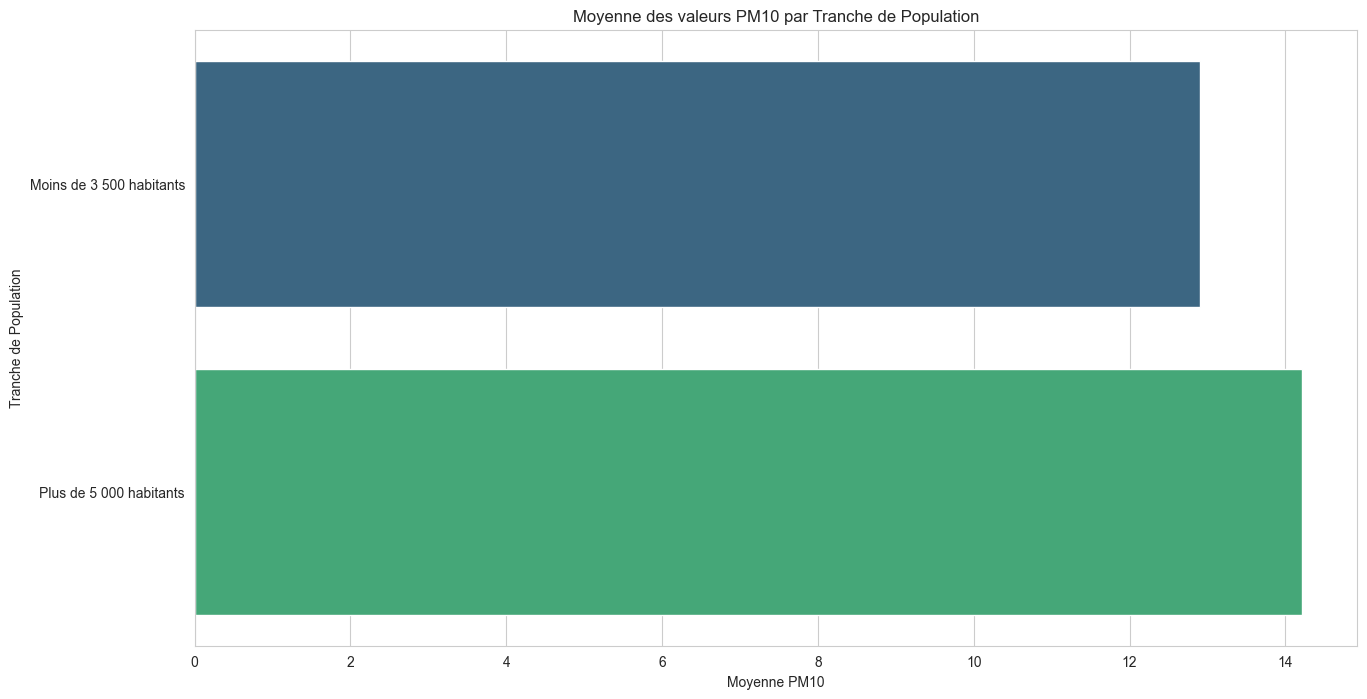

In [19]:
# Vérifier si la colonne 'tranche_population' existe
if 'tranche_population' in dfPM10.columns:
    # Calculer la moyenne de PM10 pour chaque tranche de population
    population_means = dfPM10.groupby('tranche_population')['valeur'].mean().reset_index()

    # Trier les tranches de population pour un affichage ordonné
    population_means = population_means.sort_values('tranche_population')

    # Créer un graphique en barres
    plt.figure(figsize=(15, 8))
    sns.barplot(data=population_means, x='valeur', y='tranche_population', palette='viridis', hue='tranche_population', dodge=False, legend=False)

    plt.xlabel('Moyenne PM10')
    plt.ylabel('Tranche de Population')
    plt.title('Moyenne des valeurs PM10 par Tranche de Population')
    plt.show()
else:
    print("La colonne 'tranche_population' n'existe pas dans le DataFrame.")





## Ajout d'alerte quand les variables de seuils sont dépassées
### Pour les valeurs de l'objectif de la qualité mensuel


In [20]:
import calendar
import pandas as pd

# Convertir les colonnes de date en format datetime si ce n'est pas déjà fait
dfPM10['date_heure_tu'] = pd.to_datetime(dfPM10['date_heure_tu'])

# Grouper les données par année, mois, département et commune
dfPM10['année'] = dfPM10['date_heure_tu'].dt.year
dfPM10['mois'] = dfPM10['date_heure_tu'].dt.month
grouped = dfPM10.groupby(['année', 'mois', 'departement_nom', 'nom_commune'])[['valeur']].mean().reset_index()

# Arrondir les valeurs moyennes à un chiffre après la virgule
grouped['valeur'] = grouped['valeur'].round(1)

# Créer la colonne indiquant si la moyenne mensuelle dépasse le seuil
grouped['depasse_objectif_qualite'] = grouped['valeur'] > OBJECTIF_QUALITE_PM10_MENSUEL

# Extraire les mois en lettres
grouped['mois_lettres'] = grouped['mois'].apply(lambda x: calendar.month_name[x])

# Regrouper les alertes par type
alertes_qualite = grouped[grouped['depasse_objectif_qualite']]

# Afficher les alertes par type pour les moyennes mensuelles avec le département et la commune
if not alertes_qualite.empty:
    print("Alertes pour l'Objectif de Qualité mensuel:")
    for index, row in alertes_qualite.iterrows():
        print(f"Alerte: Valeur moyenne {row['valeur']} µg/m3 dépasse l'Objectif de Qualité mensuel ({OBJECTIF_QUALITE_PM10_MENSUEL} µg/m3) en {row['mois_lettres']} {row['année']} dans la commune {row['nom_commune']} du département {row['departement_nom']}")
else:
    print("Aucune alerte pour l'Objectif de Qualité mensuel.")


Alertes pour l'Objectif de Qualité mensuel:
Alerte: Valeur moyenne 21.1 µg/m3 dépasse l'Objectif de Qualité mensuel (15 µg/m3) en janvier 2024 dans la commune bouguenais du département Loire-Atlantique
Alerte: Valeur moyenne 15.6 µg/m3 dépasse l'Objectif de Qualité mensuel (15 µg/m3) en janvier 2024 dans la commune donges du département Loire-Atlantique
Alerte: Valeur moyenne 17.5 µg/m3 dépasse l'Objectif de Qualité mensuel (15 µg/m3) en janvier 2024 dans la commune frossay du département Loire-Atlantique
Alerte: Valeur moyenne 18.2 µg/m3 dépasse l'Objectif de Qualité mensuel (15 µg/m3) en janvier 2024 dans la commune montoir-de-bretagne du département Loire-Atlantique
Alerte: Valeur moyenne 18.8 µg/m3 dépasse l'Objectif de Qualité mensuel (15 µg/m3) en janvier 2024 dans la commune nantes du département Loire-Atlantique
Alerte: Valeur moyenne 22.6 µg/m3 dépasse l'Objectif de Qualité mensuel (15 µg/m3) en janvier 2024 dans la commune reze du département Loire-Atlantique
Alerte: Valeur m

### Pour les valeurs du seuil d’information et de recommandation 

In [21]:
import calendar
import pandas as pd

# Convertir les colonnes de date en format datetime si ce n'est pas déjà fait
dfPM10['date_heure_tu'] = pd.to_datetime(dfPM10['date_heure_tu'])

# Grouper les données par département, commune et par intervalle de 24 heures
dfPM10['date'] = dfPM10['date_heure_tu'].dt.date
grouped_24h = dfPM10.groupby(['date', 'departement_nom', 'nom_commune'])[['valeur']].mean().reset_index()

# Arrondir les valeurs moyennes à un chiffre après la virgule
grouped_24h['valeur'] = grouped_24h['valeur'].round(1)

# Créer la colonne indiquant si la moyenne sur 24 heures dépasse le seuil
grouped_24h['depasse_seuil_info_reco'] = grouped_24h['valeur'] > SEUIL_INFO_RECO

# Extraire l'année et le mois pour l'affichage
grouped_24h['année'] = pd.to_datetime(grouped_24h['date']).dt.year
grouped_24h['mois'] = pd.to_datetime(grouped_24h['date']).dt.month
grouped_24h['mois_lettres'] = grouped_24h['mois'].apply(lambda x: calendar.month_name[x])

# Regrouper les alertes par type
alertes_seuil = grouped_24h[grouped_24h['depasse_seuil_info_reco']]

# Afficher les alertes par type pour les moyennes sur 24 heures avec le département et la commune
if not alertes_seuil.empty:
    print("Alertes pour le Seuil d'Information et de Recommandation sur 24 heures:")
    for index, row in alertes_seuil.iterrows():
        print(f"Alerte: Valeur moyenne {row['valeur']} µg/m3 dépasse le Seuil d'Information et de Recommandation ({SEUIL_INFO_RECO} µg/m3) le {row['date']} dans la commune {row['nom_commune']} du département {row['departement_nom']}")
else:
    print("Aucune alerte pour le Seuil d'Information et de Recommandation sur 24 heures.")


Alertes pour le Seuil d'Information et de Recommandation sur 24 heures:
Alerte: Valeur moyenne 26.2 µg/m3 dépasse le Seuil d'Information et de Recommandation (25 µg/m3) le 2024-01-03 dans la commune reze du département Loire-Atlantique
Alerte: Valeur moyenne 26.4 µg/m3 dépasse le Seuil d'Information et de Recommandation (25 µg/m3) le 2024-01-03 dans la commune saint-nazaire du département Loire-Atlantique
Alerte: Valeur moyenne 27.2 µg/m3 dépasse le Seuil d'Information et de Recommandation (25 µg/m3) le 2024-01-03 dans la commune cholet du département Maine-et-Loire
Alerte: Valeur moyenne 25.8 µg/m3 dépasse le Seuil d'Information et de Recommandation (25 µg/m3) le 2024-01-09 dans la commune saint-denis-d'anjou du département Mayenne
Alerte: Valeur moyenne 34.4 µg/m3 dépasse le Seuil d'Information et de Recommandation (25 µg/m3) le 2024-01-10 dans la commune bouguenais du département Loire-Atlantique
Alerte: Valeur moyenne 27.9 µg/m3 dépasse le Seuil d'Information et de Recommandation (

### Pour les valeurs du seuils d'alerte

In [22]:
import calendar
import pandas as pd

# Convertir les colonnes de date en format datetime si ce n'est pas déjà fait
dfPM10['date_heure_tu'] = pd.to_datetime(dfPM10['date_heure_tu'])

# Grouper les données par département, commune et par intervalle de 24 heures
dfPM10['date'] = dfPM10['date_heure_tu'].dt.date
grouped_24h = dfPM10.groupby(['date', 'departement_nom', 'nom_commune'])[['valeur']].mean().reset_index()

# Arrondir les valeurs moyennes à un chiffre après la virgule
grouped_24h['valeur'] = grouped_24h['valeur'].round(1)

# Créer la colonne indiquant si la moyenne sur 24 heures dépasse le seuil
grouped_24h['depasse_seuil_alerte'] = grouped_24h['valeur'] > SEUIL_ALERTE

# Extraire l'année et le mois pour l'affichage
grouped_24h['année'] = pd.to_datetime(grouped_24h['date']).dt.year
grouped_24h['mois'] = pd.to_datetime(grouped_24h['date']).dt.month
grouped_24h['mois_lettres'] = grouped_24h['mois'].apply(lambda x: calendar.month_name[x])

# Regrouper les alertes par type
alertes_alerte = grouped_24h[grouped_24h['depasse_seuil_alerte']]

# Afficher les alertes par type pour les moyennes sur 24 heures avec le département et la commune
if not alertes_alerte.empty:
    print("Alertes pour le Seuil d'Alerte sur 24 heures:")
    for index, row in alertes_alerte.iterrows():
        print(f"Alerte: Valeur moyenne {row['valeur']} µg/m3 dépasse le Seuil d'Alerte ({SEUIL_ALERTE} µg/m3) le {row['date']} dans la commune {row['nom_commune']} du département {row['departement_nom']}")
else:
    print("Aucune alerte pour le Seuil d'Alerte sur 24 heures.")


Alertes pour le Seuil d'Alerte sur 24 heures:
Alerte: Valeur moyenne 43.8 µg/m3 dépasse le Seuil d'Alerte (40 µg/m3) le 2024-01-14 dans la commune bouguenais du département Loire-Atlantique
Alerte: Valeur moyenne 41.1 µg/m3 dépasse le Seuil d'Alerte (40 µg/m3) le 2024-01-14 dans la commune nantes du département Loire-Atlantique
Alerte: Valeur moyenne 43.8 µg/m3 dépasse le Seuil d'Alerte (40 µg/m3) le 2024-01-14 dans la commune reze du département Loire-Atlantique
Alerte: Valeur moyenne 42.1 µg/m3 dépasse le Seuil d'Alerte (40 µg/m3) le 2024-01-14 dans la commune angers du département Maine-et-Loire
Alerte: Valeur moyenne 43.5 µg/m3 dépasse le Seuil d'Alerte (40 µg/m3) le 2024-01-14 dans la commune la roche-sur-yon du département Vendée
Alerte: Valeur moyenne 40.1 µg/m3 dépasse le Seuil d'Alerte (40 µg/m3) le 2024-02-04 dans la commune montoir-de-bretagne du département Loire-Atlantique
Alerte: Valeur moyenne 40.1 µg/m3 dépasse le Seuil d'Alerte (40 µg/m3) le 2024-02-05 dans la commune 

## Visualisation sur une carte des alertes
Mise en avant du dépassement du seuil OBJECTIF_QUALITE_PM10_MENSUEL, en rouge quand dépassé, en vert quand ok

In [23]:
import folium
# Définir la locale en français
locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')

# Conversion de la colonne date en datetime
dfPM10['date_heure_tu'] = pd.to_datetime(dfPM10['date_heure_tu'])

# Ajouter la colonne 'mois' pour grouper par mois
dfPM10['mois'] = dfPM10['date_heure_tu'].dt.month

# Calculer la moyenne mensuelle des valeurs de PM10 pour chaque département et chaque commune
monthly_means = dfPM10.groupby(['departement_nom', 'nom_commune', 'mois'])['valeur'].mean().reset_index()

# Convertir les numéros des mois en noms de mois
monthly_means['mois_lettres'] = monthly_means['mois'].apply(lambda x: calendar.month_name[x].capitalize())

# Ajouter une colonne indiquant si la moyenne mensuelle dépasse le seuil
monthly_means['depasse_seuil'] = monthly_means['valeur'] > OBJECTIF_QUALITE_PM10_MENSUEL

# Dictionnaire des villes et leurs coordonnées
coordonnees_villes = {
    "angers": [47.4724, -0.5532],
    "bouguenais": [47.1769, -1.6234],
    "cholet": [47.0657, -0.8779],
    "donges": [47.3178, -2.0759],
    "frossay": [47.2443, -1.9347],
    "la Roche-Sur-Yon": [46.6705, -1.4266],
    "la Tardière": [46.6614, -0.7323],
    "laval": [48.0706, -0.7727],
    "le Mans": [48.0061, 0.1996],
    "montoir-De-Bretagne": [47.3286, -2.1561],
    "nantes": [47.2181, -1.5528],
    "reze": [47.1906, -1.5693],
    "saint-denis-d'Anjou": [47.7905, -0.4434],
    "saint-etienne-de-montluc": [47.2745, -1.7782],
    "saint-nazaire": [47.2758, -2.2137]
}

# Créer une carte centrée sur une certaine position
m = folium.Map(location=[47.25291196744293, -1.5732745401793513], zoom_start=8)

# Coordonnées du contour de la région
contour_region = [
    [48.139820571640215, 0.917897461937213],
[48.136825379279045, 0.915487204109416],
[48.13395928423762, 0.851617967417126],
[48.12473593740404, 0.856241390135176],
[48.1068882561031, 0.844559292965461],
[48.10394308999934, 0.842462142768628],
[48.101798738958344, 0.838476779234808],
[48.09856267702027, 0.81916383199803],
[48.09550562828954, 0.817394730809342],
[48.092021393940925, 0.831540178728538],
[48.09365069806012, 0.846254465240597],
[48.07352183339798, 0.844266630102142],
[48.07219468366506, 0.839619195545604],
[48.07031923821323, 0.795237603949035],
[48.06750693024778, 0.797946906787912],
[48.038121369742775, 0.798792970730339],
[48.03746241747608, 0.808365078197161],
[48.032330099920614, 0.814589762707546],
[48.0335022685125, 0.839574558711975],
[48.01989658136905, 0.841833228552399],
[48.01002186177535, 0.837015907297354],
[48.0012807558693, 0.833590711913315],
[47.98813419819548, 0.820730622774396],
[47.98261552965844, 0.825597885524443],
[47.97344661014555, 0.830277346602219],
[47.969818382352585, 0.838093464430197],
[47.95747779284636, 0.844078700083444],
[47.95478226460014, 0.846814389205951],
[47.94480489972413, 0.849618506912329],
[47.94207236500615, 0.846433385852257],
[47.935156869436454, 0.817588265763019],
[47.92903111873998, 0.813473594924141],
[47.90911102995887, 0.81177671259338],
[47.89603802449877, 0.817054674846225],
[47.89270850531292, 0.818075542028047],
[47.89037174959481, 0.814476362771566],
[47.898845035618855, 0.799105805098443],
[47.90832599071949, 0.795312449173505],
[47.91263136858946, 0.788236878281388],
[47.902271606417386, 0.769307013576806],
[47.90085612255094, 0.764974740516186],
[47.89897198087088, 0.761037671689732],
[47.889010880839436, 0.758512804192202],
[47.86601539181144, 0.764635645427447],
[47.86010059185327, 0.760402016543799],
[47.85362893988953, 0.771335571723372],
[47.85152941080331, 0.775088876503266],
[47.841476695197336, 0.775269981256232],
[47.831978749883476, 0.769650524279934],
[47.834464339134534, 0.760225964462629],
[47.83170342292335, 0.757573518501858],
[47.82871948212086, 0.748941412530688],
[47.81344195699722, 0.741515166834662],
[47.80857143519425, 0.735025185836938],
[47.806348901217135, 0.731351510659766],
[47.79137224722905, 0.714058844043487],
[47.78809445364278, 0.713144606439799],
[47.79052538284027, 0.703927460310863],
[47.78441253316707, 0.692981737510349],
[47.77055365612444, 0.703867768695203],
[47.76506476855462, 0.698575335869012],
[47.76522078995653, 0.693680292354113],
[47.76965677123472, 0.676218396273268],
[47.76818131887721, 0.672195847645746],
[47.75600001850613, 0.652433089516439],
[47.7558097997224, 0.651506699033582],
[47.75393393938052, 0.647329314139482],
[47.752238783318155, 0.627576632025602],
[47.747047679718555, 0.621132205017031],
[47.73751772013911, 0.619181635036125],
[47.73292095848016, 0.611899905462158],
[47.729013453752685, 0.612821664986086],
[47.726172988293385, 0.609959905924394],
[47.723918391564986, 0.595314672364795],
[47.7137066221446, 0.581738935892146],
[47.713252064526, 0.581546113114206],
[47.703063628228875, 0.59402784344525],
[47.690133424563506, 0.597132530924578],
[47.687564292245725, 0.605770285870988],
[47.69253647201864, 0.612442868239426],
[47.69509613336529, 0.615662072570479],
[47.689711001044074, 0.619183548377998],
[47.68380463546474, 0.613926366325183],
[47.67093643756273, 0.590184782493164],
[47.67167867151768, 0.560021420820582],
[47.66705793883061, 0.560831841231957],
[47.66485296911657, 0.557013790581417],
[47.65804982663019, 0.546462435367108],
[47.654819750912544, 0.526965550862463],
[47.65710541213525, 0.517955077030444],
[47.64563802899048, 0.499646183644741],
[47.64596312855871, 0.494647358550483],
[47.64505661875247, 0.479724250161372],
[47.64776527821037, 0.476691577536137],
[47.64469083985046, 0.462405053158118],
[47.64147909509871, 0.460465352582851],
[47.622341714714366, 0.452623723578038],
[47.61920034096014, 0.432968264428388],
[47.62046703126597, 0.423396532981239],
[47.64173151220147, 0.397476813648857],
[47.64188639366555, 0.392738341114078],
[47.64397918149021, 0.384014504843753],
[47.64056257602143, 0.382662558728484],
[47.62295461064668, 0.365768321069734],
[47.61422458805021, 0.374457846642041],
[47.610855344690485, 0.383640246658407],
[47.595468779860305, 0.396310206838812],
[47.592246327036236, 0.398024717025753],
[47.57939761006902, 0.403801918766712],
[47.57842003438731, 0.399137744921761],
[47.56941078498642, 0.379707462506238],
[47.57139714786303, 0.375883409145042],
[47.58061542993861, 0.340330814728303],
[47.584064585383324, 0.340704276373166],
[47.5961136451465, 0.32332778962614],
[47.599987366804825, 0.276634662934619],
[47.61317873312447, 0.260338506476615],
[47.6129089448832, 0.255770316231395],
[47.61178137196868, 0.233932467236308],
[47.60928501822992, 0.231223910810554],
[47.60621654535301, 0.233607343319304],
[47.58589039227937, 0.231784388226315],
[47.57949109378813, 0.235790634571625],
[47.5781983981304, 0.231784365366029],
[47.57448108704655, 0.220158505904678],
[47.5696727374431, 0.215310873441863],
[47.54404642179804, 0.201308524177551],
[47.53892446286513, 0.194340226502062],
[47.533821304211926, 0.206870458870147],
[47.52755340337726, 0.208395965543357],
[47.52816437639886, 0.22606448498058],
[47.50607312823616, 0.220934538074542],
[47.502839840989544, 0.221328759074798],
[47.48749731169648, 0.205368859494294],
[47.48538690982457, 0.201878794795904],
[47.47730038903029, 0.200069130183308],
[47.45663602599452, 0.185465049089882],
[47.45411285080643, 0.182092897694502],
[47.43047516247728, 0.18569817094169],
[47.427104401568, 0.186367753066238],
[47.41748959455712, 0.182161188137468],
[47.40233657364222, 0.158000809315165],
[47.39961702622068, 0.155080278015628],
[47.397040044073215, 0.169465354730488],
[47.386899873027374, 0.169948138783309],
[47.382829872968784, 0.183358569823791],
[47.36620008197363, 0.158882515037754],
[47.363981029765355, 0.155075408106944],
[47.36268694048586, 0.141620835549202],
[47.3596031945026, 0.144065511809201],
[47.346264119016354, 0.148514091370897],
[47.343707167771775, 0.145654588374585],
[47.336244478134674, 0.136708745782207],
[47.333230890174946, 0.1186764236036],
[47.32972856285752, 0.119103514322312],
[47.316615219994205, 0.112322498640579],
[47.30908496558589, 0.101522849734771],
[47.287753832149114, 0.083594791628841],
[47.283269502500445, 0.089769977165821],
[47.27640560530264, 0.088698552938568],
[47.27503610350161, 0.084391906233149],
[47.272571188001194, 0.08132240516636],
[47.25281096059379, 0.077579700791038],
[47.24421307914356, 0.070308094326588],
[47.234405698987516, 0.075049089561055],
[47.22076680798951, 0.073662016486019],
[47.21723574482959, 0.077609260442693],
[47.21537237768369, 0.074087577486209],
[47.21507657538758, 0.069502626212988],
[47.199744270459256, 0.055004378965193],
[47.19184205452336, 0.063102584022559],
[47.19068246876732, 0.067803843441243],
[47.1772794630794, 0.064729331477807],
[47.168257797607254, 0.057849820958676],
[47.165499749553916, 0.054949001424109],
[47.16801679230477, 0.052275175817596],
[47.16124345066838, 0.037852431327343],
[47.16377884361873, 0.034832267675691],
[47.17664730537202, 0.020224721848942],
[47.17418809294513, 0.016740613182785],
[47.158356068491734, -0.009434104197849],
[47.12811429906696, -0.032800055940574],
[47.121507419699846, -0.033232340604998],
[47.11563543984541, -0.038300192582744],
[47.10903063358266, -0.036277740093622],
[47.10691666178501, -0.026842785010823],
[47.10356378749231, -0.025862470613764],
[47.08760790761312, -0.034108693569511],
[47.08850483821024, -0.038722722281214],
[47.09404079902318, -0.043019556095268],
[47.09426611452605, -0.06655618403234],
[47.097420632317075, -0.067527587438126],
[47.101325166219894, -0.08433492782579],
[47.09916364595058, -0.087681422838655],
[47.09224176242745, -0.096849954803265],
[47.08897306598159, -0.09877263796247],
[47.08547724752182, -0.099442760444508],
[47.07229345436816, -0.102879140398143],
[47.06568791471895, -0.100916136780966],
[47.06442159776369, -0.105774519797383],
[47.055126127511244, -0.127692249969233],
[47.05644050772846, -0.132079694570577],
[47.06524144830495, -0.136796569410565],
[47.07053410445394, -0.148591673981854],
[47.06976597252299, -0.157593459573589],
[47.06548709937373, -0.16478046583532],
[47.066961704637016, -0.169165690186055],
[47.068400419059586, -0.173549051754659],
[47.07067489880361, -0.177350457304671],
[47.08188313199359, -0.165531983450764],
[47.09766340402647, -0.139686676108224],
[47.104545983102405, -0.140048762525769],
[47.10359127554586, -0.145007360873292],
[47.10248213356913, -0.15494546875309],
[47.109307934681, -0.184035548497669],
[47.10301123949632, -0.185933320365056],
[47.094084729989014, -0.205065860774068],
[47.096798657811576, -0.207917535328636],
[47.10597206553226, -0.239226936785767],
[47.101175203317524, -0.256977412228265],
[47.10636833214428, -0.261672707498311],
[47.1038469807745, -0.264793256475039],
[47.10150006266244, -0.291307115391186],
[47.0929411647585, -0.311434867011801],
[47.09215159087085, -0.316043669272336],
[47.08816734433879, -0.338939859507877],
[47.091129899010475, -0.340864450593291],
[47.09554110616782, -0.353449125515514],
[47.09443015542544, -0.357905863075576],
[47.093413529334846, -0.362488082184614],
[47.0894472762484, -0.38075127406805],
[47.09328009796999, -0.385860391457205],
[47.092779893464574, -0.390645215870824],
[47.07166440027527, -0.399579084986863],
[47.067387413644994, -0.407421582444059],
[47.07313079568647, -0.42528734118896],
[47.06856579357149, -0.444254176759801],
[47.06923193249026, -0.459359239555193],
[47.05452373687248, -0.47918506432281],
[47.067432623303596, -0.482654876110124],
[47.07703699741445, -0.463236763207049],
[47.08275554438158, -0.462153678174083],
[47.08430048790036, -0.466553655844018],
[47.08374730720876, -0.490596494556346],
[47.078831149920035, -0.513932586595515],
[47.07693251727846, -0.518293210096924],
[47.062596247641466, -0.558519587675996],
[47.06014695046833, -0.554943259912694],
[47.04651328312459, -0.554874947076975],
[47.03600417676713, -0.54227831125939],
[47.02964979676978, -0.545815238127334],
[47.030402128726266, -0.560338443167685],
[47.02072330912225, -0.565577778973084],
[47.01578587144372, -0.578902234192775],
[47.00702921554581, -0.58605629327484],
[47.00153750917674, -0.594544970429118],
[46.99880467158448, -0.594297240133452],
[46.998436609933734, -0.599475732771284],
[46.994257263436936, -0.618982343694573],
[46.99423717725646, -0.623920616887966],
[46.99782247029206, -0.631722950691123],
[46.99515384816949, -0.64574391757922],
[47.002762414943966, -0.672106889532198],
[46.99413717142168, -0.679174248384655],
[46.988554235009836, -0.678991093546529],
[46.988894328003056, -0.683585925366378],
[46.99361185257543, -0.688544139194439],
[46.99545948380349, -0.69727229700466],
[46.993060002725855, -0.700980549180493],
[46.986887889452326, -0.713269383972424],
[46.997972188211875, -0.732607491664228],
[46.9931673387929, -0.75011114414536],
[46.99394874961538, -0.760190379006519],
[47.004256122109474, -0.771635026170852],
[47.006004739360925, -0.78565824060775],
[47.003342882222114, -0.788765010423177],
[46.992784516828706, -0.807205599677596],
[46.99034414936256, -0.803831978474553],
[46.989100272787596, -0.808486747308991],
[46.99394471567264, -0.81545474156638],
[46.993743651654135, -0.820446454293513],
[46.98841010562336, -0.833111030271379],
[46.98704378397127, -0.84652957412402],
[46.9788267282498, -0.853977978985586],
[46.97248445929324, -0.853063676674353],
[46.97135490750165, -0.857724081971509],
[46.97719372995497, -0.880886564717651],
[46.976716351008626, -0.890770214484932],
[46.975580373923556, -0.895060745741717],
[46.97120460643491, -0.901026781990027],
[46.96896887907786, -0.897032823585054],
[46.96942015870405, -0.882053708700812],
[46.96004845304999, -0.876613244360562],
[46.960259418161634, -0.866833042928056],
[46.953733805537546, -0.864128426579837],
[46.95078263132806, -0.881122298932506],
[46.947356515964515, -0.879809818141357],
[46.9461327946288, -0.874930830902427],
[46.945089522625125, -0.850650209006305],
[46.93915009495755, -0.851451476037111],
[46.932042622186366, -0.829403020889075],
[46.922604513902996, -0.823155859214429],
[46.92060350565321, -0.808725943797307],
[46.91487697394699, -0.812624106277025],
[46.90986495480794, -0.819150812655461],
[46.90347030307691, -0.817095017360922],
[46.885637769620445, -0.831272067693663],
[46.882019010880335, -0.81782939711216],
[46.86194354691265, -0.793887087993168],
[46.85874255674592, -0.792545945279728],
[46.855198896217296, -0.787107815231768],
[46.85281522952392, -0.785573947968235],
[46.841868964286355, -0.776637493295886],
[46.84125564669651, -0.77198457872594],
[46.83474858288497, -0.760379235324784],
[46.83221688568996, -0.756762456134179],
[46.829783090550286, -0.737391350379433],
[46.82244821723345, -0.728441655187446],
[46.822461934610196, -0.713800951656183],
[46.82246895163742, -0.708863797130853],
[46.81250218478489, -0.699831924811078],
[46.80975156795365, -0.697910211390026],
[46.80835299664725, -0.702436773497131],
[46.79977700106746, -0.717339570221197],
[46.79018176518123, -0.719424235602685],
[46.78381511862061, -0.723973591360042],
[46.769662994832196, -0.725375637275957],
[46.756623926458566, -0.718564541983328],
[46.75386847504379, -0.715411399652097],
[46.750585750174984, -0.706544448910891],
[46.752513950794764, -0.697050338903271],
[46.74626555319922, -0.694303424995997],
[46.736836077633235, -0.696872940717077],
[46.72674522800689, -0.687481798853296],
[46.72854021383817, -0.683211700977032],
[46.72171842634479, -0.671922303425386],
[46.70123141764858, -0.654657053375456],
[46.68769531332137, -0.676839995060661],
[46.67759122053869, -0.656550686505721],
[46.6753654604188, -0.652839254997351],
[46.66422567056281, -0.635801279697581],
[46.66202047057156, -0.639385195352136],
[46.657670507195334, -0.646634957002257],
[46.64502904170187, -0.649609083792163],
[46.64128935763164, -0.657484900604542],
[46.63484095011694, -0.655885450491306],
[46.6387031300507, -0.64190708731968],
[46.637218160728864, -0.631887686606283],
[46.621020333200946, -0.612778347103514],
[46.619370341848764, -0.616515975847476],
[46.60649719513679, -0.625965849770949],
[46.59977002304699, -0.615512395537671],
[46.59386824906524, -0.617735689274158],
[46.588506859991725, -0.612240494292515],
[46.57833441847722, -0.623513575564273],
[46.575176124224704, -0.621643683299859],
[46.562394958768046, -0.616767568895668],
[46.5632487229552, -0.612015726095854],
[46.56021283696182, -0.605383925232088],
[46.54369137737925, -0.601925746124754],
[46.54052448008034, -0.601716248738197],
[46.53417624873357, -0.600943667698501],
[46.52902250477753, -0.607472600214928],
[46.52906187634496, -0.627013117874804],
[46.525658993924324, -0.641048348140603],
[46.52018382777352, -0.637495417923693],
[46.51178208860887, -0.643175473637553],
[46.505610337609326, -0.633167511832702],
[46.50231405357172, -0.631654703152907],
[46.49766039482725, -0.624348385887348],
[46.48083417358076, -0.62737950277975],
[46.47400286371138, -0.616814257587714],
[46.463729494097116, -0.615036087327172],
[46.45510430506303, -0.607029746664474],
[46.452339394472524, -0.609794518428316],
[46.449842793666335, -0.616906317353127],
[46.44011191549392, -0.619051291964427],
[46.433202123034235, -0.635658863404896],
[46.42016687685347, -0.638231777356804],
[46.40420110665163, -0.631474096281231],
[46.39840156489961, -0.636689580419793],
[46.39134292135281, -0.619701624963008],
[46.3945113663333, -0.617865890728698],
[46.4139386248549, -0.609823110424746],
[46.4135260870258, -0.600060173680873],
[46.403126838341905, -0.580793949441914],
[46.401605902342084, -0.571207702884894],
[46.39546564158272, -0.567836425725489],
[46.39360069374568, -0.548447469529499],
[46.38983946358189, -0.540112516934165],
[46.38736045829866, -0.536617614255594],
[46.38469642638767, -0.539415551077713],
[46.36494091300987, -0.55610271277034],
[46.36183132699077, -0.558413090071349],
[46.35690610580039, -0.577256463636646],
[46.360472670267235, -0.601667908511436],
[46.347544284309265, -0.606868099318784],
[46.340603688706146, -0.618228199664344],
[46.33547517966896, -0.636068487310167],
[46.32554623198614, -0.635616219215255],
[46.3203456957781, -0.642362013670036],
[46.31859909484781, -0.646251924647994],
[46.31836952977579, -0.650895340125781],
[46.31669737226062, -0.654400142472041],
[46.31711573978775, -0.671093583755307],
[46.31895485032698, -0.67499020850568],
[46.32607690467074, -0.696157661564781],
[46.32365612823539, -0.699364453595327],
[46.31889946198248, -0.705926152068837],
[46.31777770509561, -0.715178137890243],
[46.31547432021737, -0.718624851240355],
[46.306087968815916, -0.717024272091719],
[46.30409436278947, -0.725070748228572],
[46.305156540958336, -0.749298668066526],
[46.307843533096026, -0.752279842319115],
[46.31936491348836, -0.774655277916708],
[46.31926096434417, -0.779670425952941],
[46.32521704656265, -0.791703438305437],
[46.32618399386526, -0.801634945555816],
[46.332260032306685, -0.805948581005712],
[46.33935328255201, -0.796549176595348],
[46.34335347115444, -0.802568033936817],
[46.33894023049087, -0.809993697023753],
[46.33725465723202, -0.824245521672296],
[46.34003139175909, -0.827211967204101],
[46.34225902242375, -0.835218007717535],
[46.33511112274197, -0.845622342741942],
[46.32551083329808, -0.843724360402802],
[46.31922374526511, -0.847823545739384],
[46.320038036559, -0.861842962122556],
[46.32637920079857, -0.859636141587029],
[46.326387913503474, -0.867339952125126],
[46.32335336770318, -0.869103739642722],
[46.327603144831535, -0.885672298003915],
[46.32476026744181, -0.887865142182324],
[46.31774477010198, -0.894248944929767],
[46.313648677629885, -0.91091041576048],
[46.3164317316409, -0.913868780572637],
[46.31354410964533, -0.932775259119109],
[46.32426980877975, -0.957609246472584],
[46.337855713511594, -0.942569789736537],
[46.35766070345722, -0.934298121764634],
[46.36100369716928, -0.933053962198875],
[46.36386004205248, -0.931801218723683],
[46.37183497070769, -0.926162516183424],
[46.36199325635698, -0.950315505013885],
[46.36630097035357, -0.963338430660937],
[46.36314115543541, -0.965804368240878],
[46.35209705962138, -0.977164197424229],
[46.35391022258035, -1.016464192244082],
[46.34415557423511, -1.049558627157768],
[46.3504791675023, -1.052515283858536],
[46.34731257054665, -1.054076794189975],
[46.327777947774855, -1.072164084813274],
[46.32322704088704, -1.078892372158293],
[46.32015814105555, -1.076971190710134],
[46.31469014340532, -1.094156764075881],
[46.31790025251211, -1.112927953882657],
[46.32414538809921, -1.116261297937825],
[46.32410543350355, -1.120619090069965],
[46.31557778451406, -1.122774252516374],
[46.31116899023532, -1.12823218130725],
[46.315477766936596, -1.143678628600771],
[46.31749080167893, -1.146837554174222],
[46.32333638242627, -1.158631365183303],
[46.32524668603996, -1.162603132461007],
[46.320432219717276, -1.16849613514987],
[46.316295051900106, -1.196200370168833],
[46.316988277031236, -1.20087394199618],
[46.30146864159262, -1.194789401288819],
[46.28704382980877, -1.20592196140558],
[46.28376047666313, -1.206450137577181],
[46.281808338534, -1.210709349907552],
[46.2723847496784, -1.205354109484841],
[46.27071774536665, -1.208958686888911],
[46.275752505601965, -1.222519595386435],
[46.301532506175214, -1.265365832320111],
[46.32343108721175, -1.29789742250904],
[46.321526658888494, -1.30223875363649],
[46.2979761388397, -1.293984849513713],
[46.28969663810287, -1.277242190152194],
[46.28917346968926, -1.282066014941888],
[46.2924444011753, -1.296242798428502],
[46.29506463504944, -1.299688779601389],
[46.32910837839238, -1.322778995853578],
[46.34189584270336, -1.340340975614771],
[46.3446913227124, -1.34980939716974],
[46.34674054211272, -1.353996026937539],
[46.34882954137197, -1.363501255777272],
[46.34689772091739, -1.370625609348958],
[46.34282907990635, -1.354414162967181],
[46.34047458784905, -1.352781591923697],
[46.344049732596375, -1.371752648178896],
[46.34178424196215, -1.396873227016439],
[46.34754147115885, -1.42076498368734],
[46.34194294992696, -1.439026375831977],
[46.343663806476464, -1.464221925084293],
[46.34897864649897, -1.470387072395416],
[46.36936629218964, -1.47854464078208],
[46.37263748298453, -1.480428879007031],
[46.40028209217181, -1.504000281063794],
[46.410138344338264, -1.536800188364419],
[46.40977942066164, -1.541960376582725],
[46.40636728972971, -1.549512715617122],
[46.40775402499535, -1.563110563529429],
[46.41391836805034, -1.618138078660985],
[46.42373844718298, -1.650170218055165],
[46.42679189534675, -1.647847852698387],
[46.430308263090325, -1.647651687566336],
[46.450902088908464, -1.705511612016315],
[46.459933639166756, -1.713118901049122],
[46.460185015307935, -1.72298220602194],
[46.47831144033806, -1.758296175707347],
[46.48154824247883, -1.759857562057991],
[46.48987041111425, -1.768813799485364],
[46.49520938021952, -1.781585354097262],
[46.49430456216604, -1.791328965299464],
[46.48997816419224, -1.798759739118323],
[46.495291728309525, -1.811401875223871],
[46.51550788272806, -1.817187162094662],
[46.518967489847235, -1.817309422032923],
[46.58223851325688, -1.845156900089639],
[46.58560826552052, -1.846530548731991],
[46.60931236, -1.85492847464928],
[46.618696026364006, -1.869540675631834],
[46.62849625501789, -1.874557049890241],
[46.642170859054836, -1.897213771739187],
[46.66958342490752, -1.918584608370544],
[46.672435194014085, -1.921516747205112],
[46.69261882912992, -1.940548834580859],
[46.69559673251397, -1.953682902552731],
[46.69487137085389, -1.958573766134732],
[46.6950689063154, -1.967769653796457],
[46.70393317624583, -1.976607581842309],
[46.72116685320305, -1.981758374659317],
[46.77302349270366, -2.05381223166542],
[46.77582975455945, -2.057082452891589],
[46.81730343627374, -2.137462696292781],
[46.81988651408145, -2.140823346617194],
[46.85501546382565, -2.144991691706321],
[46.85854557947952, -2.14535285540126],
[46.88906938314224, -2.153430978152701],
[46.89312803708505, -2.119122048136466],
[46.90039508073003, -2.108674368353186],
[46.90303302166178, -2.117730187240992],
[46.90985173127689, -2.115572061542174],
[46.93103831951993, -2.088853308550438],
[46.938759731283085, -2.073364645530597],
[46.93608168050636, -2.070044896708058],
[46.94275388467787, -2.071580054592346],
[46.95247433524339, -2.056734910146044],
[46.96778972407541, -2.044067013368078],
[46.98130320596853, -2.043470898268624],
[47.01047870250025, -2.026968835445004],
[47.026904670257466, -1.982125373961173],
[47.02981636752883, -1.979241775875335],
[47.06115717759077, -2.002375308770628],
[47.06743218227774, -2.014722135386574],
[47.06959038167881, -2.018831623371472],
[47.07502540638374, -2.032001490757419],
[47.09203366407153, -2.050116240878801],
[47.09515843084787, -2.052509210025062],
[47.10729147837867, -2.10035839082478],
[47.11300004473571, -2.103886141854656],
[47.11110866814747, -2.118891197763826],
[47.1127859485716, -2.144292723368462],
[47.12051815043137, -2.172365581977198],
[47.12289528255262, -2.176111075981088],
[47.125633965197736, -2.211920671639407],
[47.13606344526394, -2.242655107945574],
[47.14320344438455, -2.231237834001152],
[47.14578186776704, -2.227693791922055],
[47.15240399533207, -2.224713247791336],
[47.15699457367426, -2.211760003220349],
[47.159708438087094, -2.173449667879815],
[47.1625362729674, -2.170533786440871],
[47.168303652137226, -2.165426359488702],
[47.194935789603505, -2.159197422891316],
[47.19798152938366, -2.15705376846703],
[47.211918035935156, -2.158510118585856],
[47.23620543200279, -2.177507794746421],
[47.24450445100977, -2.169046857064235],
[47.26871560602965, -2.167322729867571],
[47.270528718490645, -2.147059302186196],
[47.27498986922516, -2.133117929313169],
[47.275522470201274, -2.128025171662248],
[47.28297248496009, -2.060966758894128],
[47.28695345356233, -2.04642780219205],
[47.290298886248266, -2.044580766844552],
[47.292639167570265, -2.041181286175857],
[47.28678337470236, -2.013772207983761],
[47.285487913137715, -2.00931623016754],
[47.2952296810285, -2.00931117412979],
[47.29848357151873, -2.009163670709195],
[47.31564417228801, -2.00909455744504],
[47.31621604666634, -2.014215310369022],
[47.305241320639, -2.031623506819746],
[47.314455648674446, -2.037356648702132],
[47.31483028567122, -2.042418524511616],
[47.30646290171122, -2.070677169577437],
[47.30696692985899, -2.106879992956104],
[47.306580767223785, -2.111949178563927],
[47.30094417504787, -2.141291080410038],
[47.290828728917695, -2.167901522424168],
[47.29947229706826, -2.180418536644192],
[47.29609019317219, -2.181816236843056],
[47.2830988596617, -2.183610761978397],
[47.27965651937721, -2.192386111297463],
[47.273416689177076, -2.197150242961027],
[47.26680390689606, -2.220619788540133],
[47.257910389762245, -2.227560192841727],
[47.25509751328386, -2.247655121997061],
[47.2404885257552, -2.268948069875969],
[47.23560097880676, -2.293413617967587],
[47.23815948864384, -2.301799493271889],
[47.254282974820015, -2.335782061924942],
[47.26648481464947, -2.34511991498111],
[47.273759955727286, -2.356398320340897],
[47.27548599911091, -2.360826272796567],
[47.282469865066695, -2.394649015853763],
[47.27505760253941, -2.422581153335465],
[47.26002366754565, -2.420081657800561],
[47.26451494876174, -2.448586461116357],
[47.26913701286657, -2.456214444062273],
[47.27624177659761, -2.490537692572687],
[47.2818668744477, -2.502649580543192],
[47.29284366438871, -2.545360340770071],
[47.29903588824385, -2.541755987467533],
[47.301174271107186, -2.516982484494539],
[47.299287210822364, -2.512635602094007],
[47.30294651017747, -2.510464870195306],
[47.31859080014594, -2.50028936925002],
[47.32559841484963, -2.499985946642578],
[47.342728560406115, -2.50601927695324],
[47.36080867746356, -2.521504540898448],
[47.36354041776162, -2.524774482965076],
[47.37449159692507, -2.555476223013645],
[47.377882155862814, -2.554591902859292],
[47.38518835284379, -2.532004473081838],
[47.4034548332509, -2.501765554569236],
[47.404805040356614, -2.49707991256448],
[47.41786105551255, -2.469584070155952],
[47.41371042772661, -2.462100924959099],
[47.413953936908136, -2.432854265419194],
[47.417328248336965, -2.431893621460378],
[47.42615007709507, -2.453531493927794],
[47.43824455002667, -2.445973267162475],
[47.44903668964157, -2.457315854857526],
[47.46187884414463, -2.451694361401425],
[47.466733398499635, -2.439175107821093],
[47.47670298818134, -2.426442181448578],
[47.478026867955194, -2.421851577520097],
[47.467815295451835, -2.418900005363543],
[47.459738572371975, -2.40923400983773],
[47.45748861428656, -2.394159323607822],
[47.46367016799569, -2.376407953725776],
[47.464094613568626, -2.366046411320826],
[47.45689273669322, -2.354747379705804],
[47.46341951681153, -2.314955864134811],
[47.48397753786733, -2.312249495773612],
[47.495759165455034, -2.301199984729569],
[47.50939122316986, -2.296068438598923],
[47.516388848801604, -2.296920924842283],
[47.51641842199595, -2.296271110317382],
[47.51179466146356, -2.278315565267667],
[47.51266175853639, -2.258347777487306],
[47.51026132112017, -2.254769687678432],
[47.501379196375716, -2.260486511554691],
[47.49620992408179, -2.247477845786384],
[47.49451343049778, -2.243105053323502],
[47.50797082375082, -2.215652144708486],
[47.51141075187702, -2.202074118529655],
[47.51204071308337, -2.197275407420766],
[47.509979253939505, -2.184425996559286],
[47.50028770995877, -2.187932255017103],
[47.494130875052136, -2.185205134674944],
[47.491788845322375, -2.16505312349825],
[47.49565440897757, -2.156614550014836],
[47.49871669653839, -2.154075211966637],
[47.50918102637195, -2.152435139824719],
[47.51963991251219, -2.153990965423104],
[47.52447208795107, -2.147532210480257],
[47.52587249618237, -2.14277888975306],
[47.53436047101024, -2.097670257322365],
[47.54113576151284, -2.095984967209468],
[47.55002366924734, -2.102709323978406],
[47.57013820848562, -2.096328863904611],
[47.573537391615496, -2.095547981934931],
[47.57607743045284, -2.102029306848115],
[47.57844946149794, -2.103882065111688],
[47.57976913246713, -2.099289198256981],
[47.596212757927404, -2.101340896788202],
[47.6041655632155, -2.085297385944362],
[47.607445887956025, -2.084116580033359],
[47.61087032499249, -2.082962987878419],
[47.62464673523159, -2.085369512859364],
[47.632271023946785, -2.095851694417596],
[47.65035883653706, -2.080868869336667],
[47.65131226183703, -2.050819360930872],
[47.66469666658824, -2.04622738033588],
[47.66660554287191, -2.04190888975824],
[47.66938583356206, -2.034133492965034],
[47.66774206258799, -2.01573984721631],
[47.6673551129229, -2.011096572130234],
[47.69256878129442, -1.975947908987314],
[47.69506393873372, -1.972213146984171],
[47.69494354072095, -1.971868461110301],
[47.68871997323863, -1.967854807888314],
[47.675145252780815, -1.968097632348792],
[47.671848454638834, -1.960151613807047],
[47.67209801033008, -1.955142101458224],
[47.687432589112206, -1.935251999075161],
[47.69639070436625, -1.886925071161008],
[47.69589751832632, -1.881884499624999],
[47.696107370028926, -1.877081214448107],
[47.70915841341603, -1.857126886236331],
[47.708943611952314, -1.852298847628254],
[47.70641021481593, -1.84033699561965],
[47.707665254521096, -1.836590259739185],
[47.71045186596695, -1.827223460156533],
[47.70651361259258, -1.81885080818152],
[47.70078666280257, -1.785084568820872],
[47.699591969989854, -1.77041735673716],
[47.70764930020865, -1.749057920196072],
[47.70505718246161, -1.734932639194443],
[47.70273874549547, -1.731401253764219],
[47.70024957419119, -1.728521845291103],
[47.70035510262019, -1.714518892289211],
[47.70083042933137, -1.709395913617812],
[47.700482204958114, -1.703783061283571],
[47.70599454578865, -1.704479995808956],
[47.708415309052704, -1.708780821040356],
[47.70720810926046, -1.704560823985057],
[47.70932151772992, -1.705141458560415],
[47.71443482535497, -1.707094292960217],
[47.714530580308974, -1.70187105423221],
[47.714137958574085, -1.695490877952282],
[47.71278208353705, -1.695042892653694],
[47.71105355245527, -1.694202208036827],
[47.71240022843645, -1.693359068708201],
[47.713397116260836, -1.68901012954054],
[47.713041563517095, -1.68526344314245],
[47.71155126092737, -1.684563157743662],
[47.712329255643176, -1.675425548279366],
[47.711639148529756, -1.673292900662553],
[47.71294458892777, -1.66764154814226],
[47.712513198874554, -1.664464905360388],
[47.71110938743429, -1.659963937850413],
[47.72121295030257, -1.647621332081499],
[47.722992962012675, -1.643193732348243],
[47.723115506826154, -1.636937049528293],
[47.74267024581175, -1.635606711912121],
[47.757465546960276, -1.624904204513451],
[47.7607329591352, -1.625936288015735],
[47.7644642930539, -1.618438125530371],
[47.7654386162435, -1.600590641825338],
[47.76743062290211, -1.596912150879273],
[47.77421952623986, -1.593714565617681],
[47.776926696608804, -1.592945382827528],
[47.77980686285408, -1.584111298304757],
[47.77914020918989, -1.574197112773703],
[47.78462212695189, -1.555231333510757],
[47.78567702917751, -1.52921072612854],
[47.79812701331422, -1.510992381995969],
[47.801986154932216, -1.502783380294531],
[47.79941007103337, -1.493801288302584],
[47.80397390970659, -1.469941820580075],
[47.80680856243901, -1.467250044815361],
[47.8249018124844, -1.473121400465888],
[47.829598641231954, -1.479487785359571],
[47.8327086290929, -1.480673640404532],
[47.83571370695608, -1.478451061092603],
[47.83575508530924, -1.463913915072885],
[47.83264549652393, -1.455378684686026],
[47.833074900408505, -1.426217053273771],
[47.82994748845371, -1.418084183321185],
[47.828401710611864, -1.413645228119237],
[47.829457375653405, -1.410762103185255],
[47.82831036873575, -1.407949724548259],
[47.825903750395476, -1.404335919813595],
[47.82944222736017, -1.390774645130917],
[47.822317249422284, -1.380027818198959],
[47.80973864499344, -1.373624021501908],
[47.8069392510953, -1.364336357683686],
[47.800570781094514, -1.363263890450718],
[47.7961170865912, -1.338792279934774],
[47.79552802532116, -1.335948430105971],
[47.7785238543256, -1.249807867709547],
[47.77761977520375, -1.244680356391089],
[47.8004990216007, -1.2358599533118],
[47.803179626940796, -1.238989487619147],
[47.80904361844647, -1.240849316369087],
[47.81089305240357, -1.237049789876975],
[47.821182553112436, -1.226669061533983],
[47.81991082543599, -1.221950542308902],
[47.82261578390928, -1.219676776211467],
[47.83704681902851, -1.214878497826129],
[47.8434063754793, -1.212974053759392],
[47.85126746039371, -1.220922094599967],
[47.85691167798393, -1.216362815503507],
[47.85811802655697, -1.211877487083252],
[47.85927967751634, -1.204899530716926],
[47.857748910517806, -1.201818453158627],
[47.86633701069413, -1.190778590950366],
[47.86860974028247, -1.187958093099061],
[47.883215553304304, -1.19664003699597],
[47.889662352641096, -1.194538004277648],
[47.89648062984072, -1.178726963795572],
[47.89861555456358, -1.174969023348764],
[47.91184414609035, -1.174509170944195],
[47.916366604413184, -1.167437773560469],
[47.928999093242076, -1.161926607534808],
[47.935074493103095, -1.165944328958258],
[47.938825253212066, -1.161585716586085],
[47.94012239582469, -1.158307767075133],
[47.95037808275695, -1.159809536137113],
[47.95383882362323, -1.160081188433981],
[47.96724505253886, -1.151257304731807],
[47.96911706093725, -1.147498620156062],
[47.97212062295253, -1.128731269202204],
[47.98728089072045, -1.120946893254273],
[47.989813873094, -1.106243316301269],
[47.98787296305841, -1.096790029812416],
[47.98839910940297, -1.091783310240305],
[47.98659812446791, -1.082154351643042],
[47.98530873955804, -1.077504378536927],
[47.98297365189515, -1.071042720468041],
[47.98384057653408, -1.067620381921307],
[47.98549653752491, -1.049157024691012],
[47.99299311117022, -1.033984010371684],
[47.993372731071794, -1.029205896954683],
[47.99630241309753, -1.020501234325836],
[48.00241451337131, -1.016992353686654],
[48.01529589809043, -1.018411764835702],
[48.01833453662891, -1.020201347176774],
[48.03339154188623, -1.03203815402618],
[48.03948790616128, -1.027411028376081],
[48.05238642762944, -1.032022214507705],
[48.061928885154, -1.027009215693158],
[48.06930387055519, -1.020284423439681],
[48.07073518245756, -1.024292060982479],
[48.078976556407696, -1.039118192302279],
[48.08750609195447, -1.046050405227492],
[48.090487353318004, -1.047920541360171],
[48.10380697177213, -1.049922312493106],
[48.10694391364028, -1.05172276133893],
[48.12335575468786, -1.055807943067901],
[48.126377456195726, -1.058072407094446],
[48.14962979150994, -1.059470144734888],
[48.1603818473421, -1.06773072426842],
[48.160200713862125, -1.072711758692912],
[48.16667631740554, -1.071487690882918],
[48.17777467905057, -1.078609399969407],
[48.180865986426625, -1.077015581490257],
[48.20404992234455, -1.076435975044507],
[48.20604820744618, -1.080673736991316],
[48.20860636728508, -1.083055681647694],
[48.210939750481245, -1.085905290948991],
[48.21712585378388, -1.081315430068938],
[48.22040041525721, -1.079385986418082],
[48.25221005659036, -1.097457131576862],
[48.26926653804336, -1.098716672850841],
[48.27378201830393, -1.092426821945917],
[48.29102525097996, -1.087247839030357],
[48.310579788859435, -1.064657956488822],
[48.31199155508153, -1.059743843487019],
[48.31308670951214, -1.058004758769635],
[48.33055433683377, -1.044611680815623],
[48.33902784832594, -1.052384773910705],
[48.342034054974754, -1.054562091221583],
[48.36771803247501, -1.05851732451711],
[48.36812771861151, -1.063618880939959],
[48.37672123810044, -1.056035075541743],
[48.3800866628885, -1.05536191501151],
[48.38182003884778, -1.051573723344573],
[48.400819897658856, -1.063103822576985],
[48.41480313689086, -1.078258997986085],
[48.41827158808534, -1.078514532474272],
[48.41938782540758, -1.077234603292163],
[48.422908645471686, -1.07700736490028],
[48.436135582551, -1.08137851168115],
[48.44280236845284, -1.079013411671129],
[48.44957567516983, -1.067500546083182],
[48.4521509595725, -1.06411247350333],
[48.46123185678253, -1.065939185314071],
[48.46781312188742, -1.063429156106203],
[48.47580325920965, -1.072353432288975],
[48.4919853468963, -1.076170302023179],
[48.50203315331147, -1.07369873770187],
[48.506514040845154, -1.06623814412724],
[48.509393476648825, -1.068942541135696],
[48.51398095515634, -1.061761055622827],
[48.51628187594611, -1.059539539241498],
[48.49388529152454, -1.010616211628852],
[48.489968661961406, -1.001752676453896],
[48.49572426456067, -0.972553266770113],
[48.50358539779318, -0.9626436152982],
[48.51367369638172, -0.961006696640212],
[48.51769011882008, -0.952660430279557],
[48.515540083596726, -0.942818311292706],
[48.51403767091362, -0.922641587496451],
[48.501618774201276, -0.916860784181059],
[48.49816817524554, -0.908131996109889],
[48.498380424839766, -0.89813297599619],
[48.49575998230734, -0.894807655067925],
[48.50078899274161, -0.863278203991145],
[48.50235633445737, -0.859138745295826],
[48.49873831953887, -0.844601723052908],
[48.47808371604496, -0.825748961970427],
[48.47697410560723, -0.820763581537233],
[48.475028444248096, -0.816856464561647],
[48.4693278942187, -0.817376103538448],
[48.458363153929966, -0.813869822274482],
[48.45581751599987, -0.811518595473368],
[48.46616417614873, -0.792198714878364],
[48.46630862450285, -0.77664936577246],
[48.4467140200465, -0.774846364042662],
[48.443601884412864, -0.77274104544987],
[48.437308657569005, -0.759592759203828],
[48.437833311671305, -0.755258020388007],
[48.45178273522891, -0.714704792097547],
[48.460784570627894, -0.730358743315477],
[48.466804585735744, -0.733956689095095],
[48.472944948137126, -0.72885366288606],
[48.47435757339786, -0.724024010551047],
[48.47123075694129, -0.715743613600315],
[48.473773171946625, -0.702108145700033],
[48.470589655025165, -0.700814003459104],
[48.469170213346786, -0.691435779366168],
[48.47032400068068, -0.686764103234428],
[48.47158610287524, -0.682382583572337],
[48.47783469677352, -0.682443114050337],
[48.48418547598493, -0.667850542609217],
[48.48735326690632, -0.66761245713055],
[48.475741184587214, -0.656926874022133],
[48.45834442201474, -0.652761981826956],
[48.45479925906208, -0.652678091345538],
[48.44544105647559, -0.652988412163751],
[48.46150735302541, -0.612401295173207],
[48.47163538072262, -0.597700207418782],
[48.47341423169646, -0.593081605934835],
[48.47173616083349, -0.591978659534367],
[48.47097415462534, -0.574578605926581],
[48.4698204196832, -0.570409772446835],
[48.47544828239524, -0.566228785816249],
[48.477742280399234, -0.563025377593576],
[48.47469297209811, -0.561098777029791],
[48.47386026667895, -0.551926959284794],
[48.48977822943518, -0.536653335145046],
[48.49244260914946, -0.533677206972506],
[48.49844620794585, -0.517401754330893],
[48.5074248937994, -0.511567755175236],
[48.50973533039809, -0.508062904387566],
[48.503012269175606, -0.491434705796437],
[48.50246374733587, -0.476980383579986],
[48.51361034726063, -0.459762103420032],
[48.51371076959754, -0.449495281502307],
[48.515829915711564, -0.445650357918501],
[48.51109516257721, -0.427233742177668],
[48.50908532811213, -0.423240047453445],
[48.50825622360703, -0.424216061374881],
[48.50878279800444, -0.399628434137692],
[48.51140404577346, -0.396423368126041],
[48.51052543311593, -0.392205799145015],
[48.50196480568243, -0.392113254590267],
[48.500263160179486, -0.388020144674358],
[48.49699225634152, -0.374518569749587],
[48.49644035637151, -0.369850134649165],
[48.488432146298585, -0.36458052562178],
[48.48466604276419, -0.351918737273427],
[48.497389000323984, -0.35254277769014],
[48.50331357460256, -0.335591387278454],
[48.50997532719924, -0.333738124035427],
[48.52381253765487, -0.319003800525028],
[48.52116127097367, -0.311069991986892],
[48.51921959750506, -0.307721159294474],
[48.51776285830253, -0.288846249529604],
[48.51606069184147, -0.28464627746153],
[48.50954024003973, -0.284048727468335],
[48.50834393567744, -0.270315486816303],
[48.52154903969041, -0.267140989237886],
[48.528980602301544, -0.249601948882269],
[48.53795410498305, -0.241807201766666],
[48.550024914471436, -0.259341791896929],
[48.552846694164, -0.256235297784137],
[48.560045405132854, -0.245845820700632],
[48.56888205396514, -0.241401965570843],
[48.56284250337058, -0.229444398963994],
[48.560680030205404, -0.214554597940653],
[48.56341071309712, -0.20610856753166],
[48.55911813929258, -0.198345572751501],
[48.55679625725319, -0.19462465881238],
[48.5548839644588, -0.19207997818152],
[48.552568107451826, -0.190487952397676],
[48.54951354685271, -0.188254154884056],
[48.54254038117704, -0.17801379960684],
[48.52864229592459, -0.143366418655209],
[48.52205038047413, -0.144150599026523],
[48.51559634752876, -0.165431875874539],
[48.50302827123197, -0.170851169723999],
[48.50386224612032, -0.166240835441168],
[48.49420088263863, -0.154455202171481],
[48.49102844152576, -0.154210647512642],
[48.48805001074526, -0.153814893702027],
[48.47984300988514, -0.148933431003676],
[48.477836815666464, -0.152279182530043],
[48.47249616550773, -0.146894876804348],
[48.4596805737394, -0.147723879580853],
[48.4551877411076, -0.140944457686845],
[48.4537089480736, -0.136605168732156],
[48.449123073399136, -0.117235040286489],
[48.44891402079684, -0.107018983152585],
[48.45059591816577, -0.07910354482673],
[48.458118149626976, -0.066089833324181],
[48.45740393318774, -0.061310333743087],
[48.45439980329286, -0.052108572283334],
[48.44474096627378, -0.049273257169374],
[48.43146598385056, -0.053980896588416],
[48.42997397600405, -0.056343908990372],
[48.394386113436546, -0.052421532123761],
[48.39107684389784, -0.052243165863657],
[48.38566770227582, -0.056011673198323],
[48.382892729151116, -0.053295444018409],
[48.37602228514848, -0.048437457585541],
[48.379056714658766, -0.050166780972617],
[48.388676379749846, -0.02086495054689],
[48.39482001740245, -0.018932554534447],
[48.39816386692856, -0.005],
[48.39687603710439, 0.00460728442271],
[48.390531854182335, 0.006482606251089],
[48.38246147393948, 0.019918631116443],
[48.381095007217645, 0.02432043202584],
[48.381270192066474, 0.036690105710927],
[48.38129519895117, 0.040919485639489],
[48.383915665681904, 0.06376248083504],
[48.39236807734237, 0.055719703303292],
[48.4042682144847, 0.06543734724802],
[48.40694814490912, 0.068599980626518],
[48.40961169949163, 0.080960134310734],
[48.41101701724696, 0.085020032980346],
[48.41191433626596, 0.084915018116364],
[48.41184246712492, 0.100687032651135],
[48.423903868855604, 0.110572046113295],
[48.42701311480813, 0.108141891415278],
[48.43319571031872, 0.112832932099735],
[48.43704281898593, 0.118899681626994],
[48.436865362829636, 0.123076976668668],
[48.43507022792837, 0.12701730791062],
[48.43799081653368, 0.149938304606632],
[48.43882185402151, 0.154559752586388],
[48.44396486060325, 0.159557540267962],
[48.44618683604176, 0.156122721902591],
[48.453055366010425, 0.147089126027431],
[48.45582612426189, 0.145166535762174],
[48.45751874915119, 0.153762896920092],
[48.45037971710709, 0.170308218999636],
[48.451766621807025, 0.174888843541855],
[48.458087579971455, 0.171529707879489],
[48.464715844668675, 0.173568381316133],
[48.463691662956144, 0.188025840347593],
[48.463219577435595, 0.193194304298681],
[48.46462230058584, 0.19619238103109],
[48.473720644453586, 0.21480840338813],
[48.47468789646533, 0.219210085654329],
[48.47402769723792, 0.222900817673166],
[48.47374694642373, 0.226706567362109],
[48.4775275193719, 0.260027925855566],
[48.48022147868379, 0.262893577507789],
[48.483748333431755, 0.263967826063438],
[48.485462126012244, 0.268049608830788],
[48.481768501271546, 0.280035469819329],
[48.4823269245461, 0.284799565903504],
[48.480701585405036, 0.299153211514723],
[48.47416273701574, 0.310874369285166],
[48.474071031390025, 0.315983093601241],
[48.47278851865576, 0.325768021350223],
[48.46370392331402, 0.338073776730916],
[48.46185277812196, 0.342241573398641],
[48.459535424240386, 0.351330941329593],
[48.46057024120398, 0.354134852088993],
[48.452446615357594, 0.364450007258322],
[48.44218626278109, 0.368942104867364],
[48.438615193661974, 0.369053462314159],
[48.43375930782778, 0.374557815652049],
[48.43119935776245, 0.377256343524243],
[48.425672610779614, 0.382969031229012],
[48.41580382233779, 0.380755718440786],
[48.41101662346559, 0.373909921944557],
[48.39098343198405, 0.376964011028228],
[48.38785480008655, 0.375106736819777],
[48.386281140882986, 0.378023560213238],
[48.38410843894955, 0.37990286846732],
[48.37367924750865, 0.382110300047646],
[48.37016097735152, 0.381799502275204],
[48.35147910457602, 0.388590412328271],
[48.34819738105189, 0.388725710010098],
[48.343941234074755, 0.381875359204189],
[48.33375971368034, 0.385136073955958],
[48.322183873403766, 0.396603013834757],
[48.31720735746604, 0.409807259472095],
[48.32236437965638, 0.41677444238196],
[48.31840341949935, 0.427509133919167],
[48.31574221601486, 0.428894808511443],
[48.309563064444426, 0.431206853776601],
[48.30692978234282, 0.439728341653563],
[48.305511260496104, 0.444035035954209],
[48.30616735263864, 0.464512230698496],
[48.30093000179519, 0.477231369971127],
[48.30804944316594, 0.492826659238274],
[48.29454166746292, 0.507067611778364],
[48.29068119900907, 0.499048346740874],
[48.28437113192761, 0.495665938172593],
[48.268469390917005, 0.513816067330157],
[48.26682987843924, 0.527052744226293],
[48.26638355261958, 0.531549824911591],
[48.26066253828455, 0.537803122228942],
[48.25368424681575, 0.538574115777813],
[48.25011974022426, 0.538578433200213],
[48.25103644703653, 0.548038871095692],
[48.24579966195988, 0.575654448615329],
[48.24529502298453, 0.580434807786013],
[48.24542932956411, 0.594970747679993],
[48.24361760664491, 0.614379370874603],
[48.2457949761156, 0.623700295087689],
[48.23839249697778, 0.630732032923022],
[48.23549747328375, 0.633152275261678],
[48.23638891636157, 0.636306031107843],
[48.236492994603644, 0.639724459919054],
[48.25233885789421, 0.63266532940452],
[48.255634241362195, 0.633152045040044],
[48.26241288747847, 0.643995383458137],
[48.26427194347505, 0.653714272072268],
[48.255966088564236, 0.680342180721262],
[48.2548727796579, 0.685161882585394],
[48.24167259798964, 0.688625008163259],
[48.207161953821824, 0.721594401940365],
[48.20364988740648, 0.721504638525132],
[48.20139951940281, 0.723392364386787],
[48.199025017617544, 0.724881961435929],
[48.19903493038571, 0.733363396292751],
[48.190067769992886, 0.739873532019411],
[48.18479685616754, 0.752349603991239],
[48.18299585452997, 0.75657119888813],
[48.18097277021713, 0.760453723045942],
[48.19394407638512, 0.794436418303009],
[48.19533264233466, 0.798901524048189],
[48.18903892777195, 0.798772950990217],
[48.185602751523305, 0.812484611549048],
[48.17391932294814, 0.829105305052849],
[48.1699202862947, 0.834355528107891],
[48.16849853264889, 0.837804793530737],
[48.166411938934985, 0.84181997478491],
[48.16753284154528, 0.861878219877659],
[48.1627227123463, 0.885698380429024],
[48.150951668484005, 0.910610579654384],
[48.14784731196719, 0.912711226080377],
[48.1444033167431, 0.910857336712615],
[48.139820571640215, 0.917897461937213]
]

# Créer un polygone représentant le contour de la région à contourner
folium.Polygon(locations=contour_region, color='red', fill=True, fill_color='blue', fill_opacity=0.2).add_to(m)

# Ajouter les marqueurs à la carte
for ville, coordonnees in coordonnees_villes.items():
    if ville in monthly_means['nom_commune'].values:
        moyenne_ville = monthly_means[monthly_means['nom_commune'] == ville]['valeur'].mean()
        depasse_seuil = moyenne_ville > OBJECTIF_QUALITE_PM10_MENSUEL
        color = 'red' if depasse_seuil else 'green'
        folium.CircleMarker(coordonnees, radius=8, popup=f"{ville}: {moyenne_ville:.2f} µg/m³", color=color, fill=True, fill_color=color, fill_opacity=1).add_to(m)
    else:
        folium.CircleMarker(coordonnees, radius=8, popup=f"{ville}: Données non disponibles", color='black', fill=True, fill_color='black', fill_opacity=1).add_to(m)

# Afficher la carte
m.save('map.html')

# Affichage textuel des communes et de leurs valeurs mensuelles
print("Liste des communes et de leurs valeurs mensuelles de PM10 :\n")
for ville in coordonnees_villes.keys():
    if ville in monthly_means['nom_commune'].values:
        moyenne_ville = monthly_means[monthly_means['nom_commune'] == ville]['valeur'].mean()
        depasse_seuil = moyenne_ville > OBJECTIF_QUALITE_PM10_MENSUEL
        statut = "Dépasse le seuil" if depasse_seuil else "Ne dépasse pas le seuil"
        print(f"{ville} : {moyenne_ville:.2f} µg/m³ - {statut}")
    else:
        print(f"{ville} : Données non disponibles")

Liste des communes et de leurs valeurs mensuelles de PM10 :

angers : 14.24 µg/m³ - Ne dépasse pas le seuil
bouguenais : 15.61 µg/m³ - Dépasse le seuil
cholet : 15.08 µg/m³ - Dépasse le seuil
donges : 12.38 µg/m³ - Ne dépasse pas le seuil
frossay : 13.39 µg/m³ - Ne dépasse pas le seuil
la Roche-Sur-Yon : Données non disponibles
la Tardière : Données non disponibles
laval : 13.38 µg/m³ - Ne dépasse pas le seuil
le Mans : Données non disponibles
montoir-De-Bretagne : Données non disponibles
nantes : 14.68 µg/m³ - Ne dépasse pas le seuil
reze : 17.24 µg/m³ - Dépasse le seuil
saint-denis-d'Anjou : Données non disponibles
saint-etienne-de-montluc : 12.78 µg/m³ - Ne dépasse pas le seuil
saint-nazaire : 15.09 µg/m³ - Dépasse le seuil


In [24]:
m

## Ajout des entreprises
Pour les entreprises, après plusieurs tests nous arrivons à récupérer toutes la liste des entreprises, mais quand on fusionne les deux jeux de données, comme nous récupérons les données horaires, la quantité de données devient beaucoup trop importante. C'est pourquoi nous avons décidé de prendre les données à granularité mensuel et non horaire pour traiter les entreprises.

In [25]:
import importlib
import PM10_mensuel

# Recharger le module pour prendre en compte les modifications
importlib.reload(PM10_mensuel)

# Importer la fonction depuis le fichier Python
from PM10_mensuel import fetch_and_process_pm10_mensuel_data

# Utilisation de la fonction importée
dfPM10_mensuel = fetch_and_process_pm10_mensuel_data()

# Vérifier si le DataFrame a été correctement récupéré et traité
if dfPM10_mensuel is not None:
    # Afficher les premières lignes du DataFrame dfPM10 pour vérifier les modifications
    print(dfPM10_mensuel.head())

    # Afficher les types de colonnes pour vérifier les conversions
    print(dfPM10_mensuel.dtypes)

Total records retrieved: 57
                                  id code_polluant code_point_de_prelevement  \
0  2024-03-01 00:00:00FR23003_PM10_1            24              FR23003_PM10   
1  2024-03-01 00:00:00FR23068_PM10_4            24              FR23068_PM10   
2  2024-03-01 00:00:00FR23070_PM10_3            24              FR23070_PM10   
3  2024-03-01 00:00:00FR23078_PM10_2            24              FR23078_PM10   
4  2024-03-01 00:00:00FR23107_PM10_4            24              FR23107_PM10   

  code_station               nom_station               nom_commune  \
0      FR23003              LA MEGRETAIS                    Donges   
1      FR23068                   FROSSAY                   Frossay   
2      FR23070  SAINT ETIENNE DE MONTLUC  Saint-Etienne-De-Montluc   
3      FR23078             SAINT EXUPERY                    Cholet   
4      FR23107            LA CHAUVINIERE                    Nantes   

  code_commune departement_code   departement_nom  code_zone_affichage

In [26]:
# Importer les bibliothèques nécessaires
import importlib
import entreprise

# Recharger le module pour prendre en compte les modifications
importlib.reload(entreprise)

# Importer la fonction depuis le fichier Python
from entreprise import fetch_data

# Utilisation de la fonction importée pour récupérer les données d'entreprises
dfEtp = fetch_data()

# Afficher les premières lignes du DataFrame dfEtp pour vérifier les modifications
print(dfEtp.head())

# Afficher les types de colonnes pour vérifier les conversions
print(dfEtp.dtypes)
print(dfEtp.shape)


            siret categorieentreprise  \
0  48883215500029                 PME   
1  39331063600021                 PME   
2  84379749900012                 PME   
3  81927682500018                None   
4  49477092800047                None   

                                sectionetablissement  \
0  Commerce ; réparation d'automobiles et de moto...   
1  Activités spécialisées, scientifiques et techn...   
2                                       Construction   
3                             Activités immobilières   
4                             Activités immobilières   

  libellecommuneetablissement etatadministratifetablissement  \
0                      angers                          Actif   
1                      angers                          Actif   
2                      angers                          Actif   
3                      cholet                          Actif   
4                      angers                          Actif   

   geolocetablissement.lon  geo

In [27]:
print(dfEtp['libellecommuneetablissement'].value_counts())

libellecommuneetablissement
nantes                      86821
angers                      34788
le mans                     28093
saint-nazaire               13214
la roche-sur-yon            12023
laval                       11650
cholet                      10930
reze                         8146
bouguenais                   3633
saint-etienne-de-montluc     1407
montoir-de-bretagne          1100
donges                        984
frossay                       546
Name: count, dtype: int64


In [28]:
# Fusionner les deux DataFrames en utilisant les colonnes 'nom_commune' et 'libellecommuneetablissement' avec une jointure externe gauche
if 'nom_commune' in dfPM10_mensuel.columns and 'libellecommuneetablissement' in dfEtp.columns:
    dfMerged = pd.merge(dfPM10_mensuel, dfEtp, left_on='nom_commune', right_on='libellecommuneetablissement', how='left', suffixes=('_pm10', '_etp'))
    
    # Sauvegarder le DataFrame fusionné pour utilisation ultérieure
    dfMerged.to_pickle('MergedData.pkl')

    # Afficher les premières lignes du DataFrame fusionné
    print("dfMerged:")
    print(dfMerged.head())
else:
    print("Les colonnes de fusion 'nom_commune' et 'libellecommuneetablissement' ne sont pas présentes dans les DataFrames. Vérifiez les colonnes disponibles.")

# Charger le DataFrame depuis le fichier sauvegardé
dfPM10_mensuel = pd.read_pickle('MergedData.pkl')

# Afficher les types de chaque colonne
print(dfPM10_mensuel.dtypes)

dfMerged:
                                  id  code_polluant code_point_de_prelevement  \
0  2024-03-01 00:00:00FR23003_PM10_1             24              FR23003_PM10   
1  2024-03-01 00:00:00FR23003_PM10_1             24              FR23003_PM10   
2  2024-03-01 00:00:00FR23003_PM10_1             24              FR23003_PM10   
3  2024-03-01 00:00:00FR23003_PM10_1             24              FR23003_PM10   
4  2024-03-01 00:00:00FR23003_PM10_1             24              FR23003_PM10   

  code_station   nom_station nom_commune  code_commune  departement_code  \
0      FR23003  LA MEGRETAIS      donges         44052                44   
1      FR23003  LA MEGRETAIS      donges         44052                44   
2      FR23003  LA MEGRETAIS      donges         44052                44   
3      FR23003  LA MEGRETAIS      donges         44052                44   
4      FR23003  LA MEGRETAIS      donges         44052                44   

    departement_nom  code_zone_affichage  ... 

In [29]:
dfPM10_mensuel.shape

(1246893, 23)

In [30]:
dfPM10_mensuel.info

<bound method DataFrame.info of                                         id  code_polluant  \
0        2024-03-01 00:00:00FR23003_PM10_1             24   
1        2024-03-01 00:00:00FR23003_PM10_1             24   
2        2024-03-01 00:00:00FR23003_PM10_1             24   
3        2024-03-01 00:00:00FR23003_PM10_1             24   
4        2024-03-01 00:00:00FR23003_PM10_1             24   
...                                    ...            ...   
1246888  2024-01-01 00:00:00FR23251_PM10_1             24   
1246889  2024-01-01 00:00:00FR23251_PM10_1             24   
1246890  2024-01-01 00:00:00FR23251_PM10_1             24   
1246891  2024-01-01 00:00:00FR23251_PM10_1             24   
1246892  2024-01-01 00:00:00FR23251_PM10_1             24   

        code_point_de_prelevement code_station      nom_station nom_commune  \
0                    FR23003_PM10      FR23003     LA MEGRETAIS      donges   
1                    FR23003_PM10      FR23003     LA MEGRETAIS      donges  

### Visualisation des données des entreprises

In [31]:
for col in dfPM10.select_dtypes('object'):
    print(f'{col :-<20} {dfPM10[col].unique()}')

id------------------ ['2024-03-31 23:00:00FR23003_PM10_1' '2024-03-31 23:00:00FR23068_PM10_4'
 '2024-03-31 23:00:00FR23070_PM10_3' ...
 '2024-01-01 00:00:00FR23242_PM10_1' '2024-01-01 00:00:00FR23249_PM10_1'
 '2024-01-01 00:00:00FR23251_PM10_1']
code_point_de_prelevement ['FR23003_PM10' 'FR23068_PM10' 'FR23070_PM10' 'FR23107_PM10'
 'FR23110_PM10' 'FR23120_PM10' 'FR23123_PM10' 'FR23124_PM10'
 'FR23152_PM10' 'FR23177_PM10' 'FR23178_PM10' 'FR23182_PM10'
 'FR23188_PM10' 'FR23238_PM10' 'FR23239_PM10' 'FR23242_PM10'
 'FR23249_PM10' 'FR23251_PM10' 'FR23078_PM10']
code_station-------- ['FR23003' 'FR23068' 'FR23070' 'FR23107' 'FR23110' 'FR23120' 'FR23123'
 'FR23124' 'FR23152' 'FR23177' 'FR23178' 'FR23182' 'FR23188' 'FR23238'
 'FR23239' 'FR23242' 'FR23249' 'FR23251' 'FR23078']
nom_station--------- ['LA MEGRETAIS' 'FROSSAY' 'SAINT ETIENNE DE MONTLUC' 'LA CHAUVINIERE'
 'LEON BLUM' 'BEAUX ARTS' 'MAZAGRAN' 'LA TARDIERE' 'DELACROIX'
 "SAINT DENIS D'ANJOU" 'PARSCAU DU PLESSIS' 'SOURCES' 'CIM BOUTEILLE

TypeError: unhashable type: 'list'

Colonnes disponibles dans top_pm10_merged: Index(['id', 'code_polluant', 'code_point_de_prelevement', 'code_station',
       'nom_station', 'nom_commune', 'code_commune', 'departement_code',
       'departement_nom', 'code_zone_affichage', 'date_heure_tu',
       'date_heure_local', 'valeur_originale', 'valeur', 'validite',
       'code_configuration_de_mesure', 'siret', 'categorieentreprise',
       'sectionetablissement', 'libellecommuneetablissement',
       'etatadministratifetablissement', 'geolocetablissement.lon',
       'geolocetablissement.lat'],
      dtype='object')
Aucune légende trouvée à afficher.


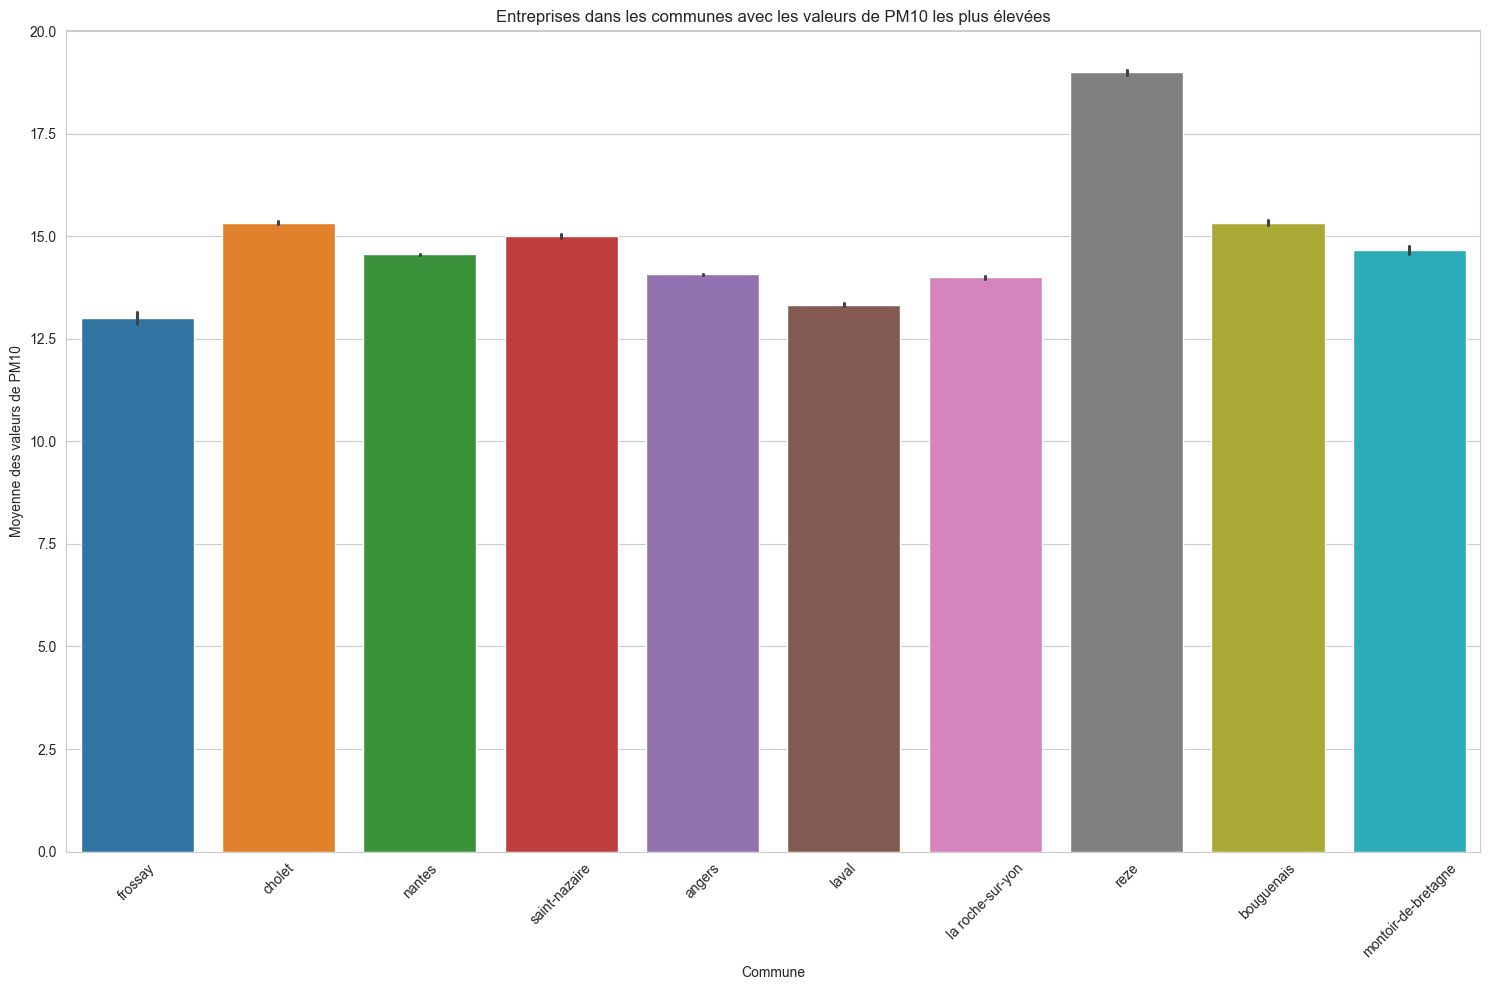

In [32]:
# Calculer les moyennes des valeurs de PM10 par commune
average_pm10_by_commune = dfPM10_mensuel.groupby('nom_commune')['valeur'].mean().reset_index()

# Trier les communes par les moyennes de PM10
top_pm10_communes = average_pm10_by_commune.sort_values(by='valeur', ascending=False).head(10)

# Filtrer dfPM10_mensuel pour ne garder que les communes avec les PM10 les plus élevées
top_pm10_merged = dfPM10_mensuel[dfPM10_mensuel['nom_commune'].isin(top_pm10_communes['nom_commune'])]

# Vérifier les colonnes disponibles
print("Colonnes disponibles dans top_pm10_merged:", top_pm10_merged.columns)

# Créer le graphique
plt.figure(figsize=(15, 10))
sns.barplot(x='nom_commune', y='valeur', data=top_pm10_merged, hue='libellecommuneetablissement')
plt.title('Entreprises dans les communes avec les valeurs de PM10 les plus élevées')
plt.xlabel('Commune')
plt.ylabel('Moyenne des valeurs de PM10')
plt.xticks(rotation=45)

# Ajouter manuellement la légende si nécessaire
handles, labels = plt.gca().get_legend_handles_labels()
if handles:
    plt.legend(title='Entreprise', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    print("Aucune légende trouvée à afficher.")

plt.tight_layout()

# Afficher le graphique
plt.show()


Voici une interprétation du graphique qui montre les moyennes des valeurs de PM10 pour les différentes communes :

1. **Axes** :
   - L'axe des abscisses (horizontal) représente les noms des communes.
   - L'axe des ordonnées (vertical) représente la moyenne des valeurs de PM10.

2. **Barres** :
   - Chaque barre représente la moyenne des valeurs de PM10 pour une commune spécifique.
   - La hauteur de la barre indique le niveau moyen de PM10. Plus la barre est haute, plus la moyenne des valeurs de PM10 est élevée.

3. **Observations** :
   - **Commune avec la valeur de PM10 la plus élevée** : Rezé a la valeur moyenne de PM10 la plus élevée, avec une moyenne d'environ 18.
   - **Autres communes avec des valeurs élevées** : Les communes comme Cholet, Nantes, Saint-Nazaire, Angers, Laval, et La Roche-sur-Yon montrent également des valeurs de PM10 relativement élevées, toutes autour de 15.
   - **Commune avec la valeur de PM10 la plus basse** : Frossay a la moyenne de PM10 la plus basse parmi les communes affichées, avec une moyenne d'environ 12.5.

4. **Interprétation générale** :
   - Ce graphique permet de comparer directement les niveaux de pollution par PM10 entre différentes communes. On peut rapidement identifier les communes où la pollution est la plus élevée et celles où elle est la plus basse.
   - Les communes avec des valeurs moyennes plus élevées peuvent nécessiter des actions plus ciblées pour réduire les niveaux de PM10 et améliorer la qualité de l'air.
   - L'homogénéité des valeurs moyennes dans certaines communes (barres de hauteur similaire) peut indiquer des sources de pollution similaires ou des conditions environnementales semblables.

En résumé, ce graphique aide à visualiser et comparer les niveaux moyens de pollution par PM10 dans différentes communes, mettant en évidence les zones à fort taux de pollution qui pourraient nécessiter une attention particulière pour améliorer la qualité de l'air.

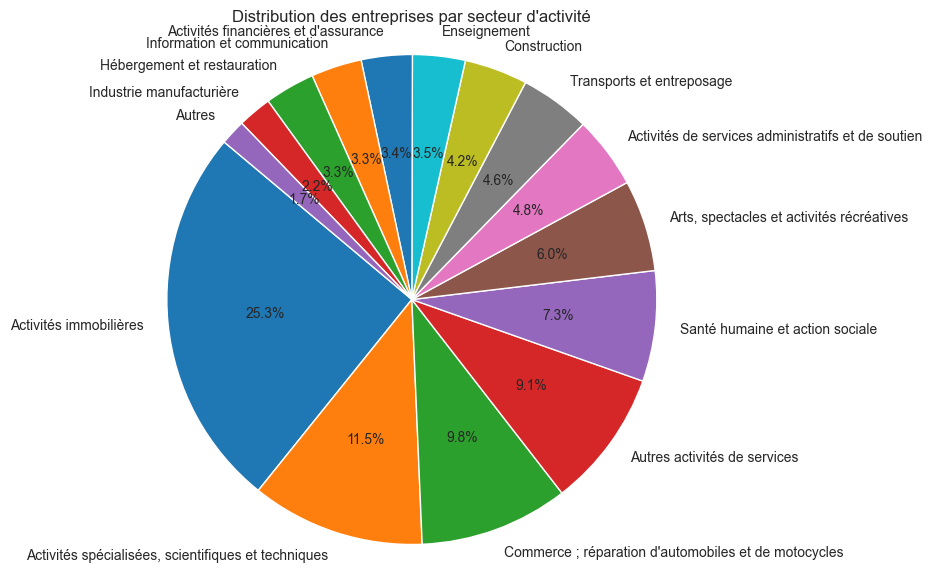

In [33]:
# Calculer la distribution des entreprises par secteur d'activité
sector_distribution = dfEtp['sectionetablissement'].value_counts()

# Filtrer les secteurs avec des valeurs inférieures à 2%
total = sector_distribution.sum()
sector_distribution_filtered = sector_distribution[sector_distribution / total >= 0.02]
sector_distribution_filtered['Autres'] = sector_distribution[sector_distribution / total < 0.02].sum()

# Créer un graphique en camembert
plt.figure(figsize=(10, 7))
plt.pie(sector_distribution_filtered, labels=sector_distribution_filtered.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution des entreprises par secteur d\'activité')
plt.axis('equal')  # Assurer que le camembert est dessiné comme un cercle

# Afficher le graphique
plt.show()


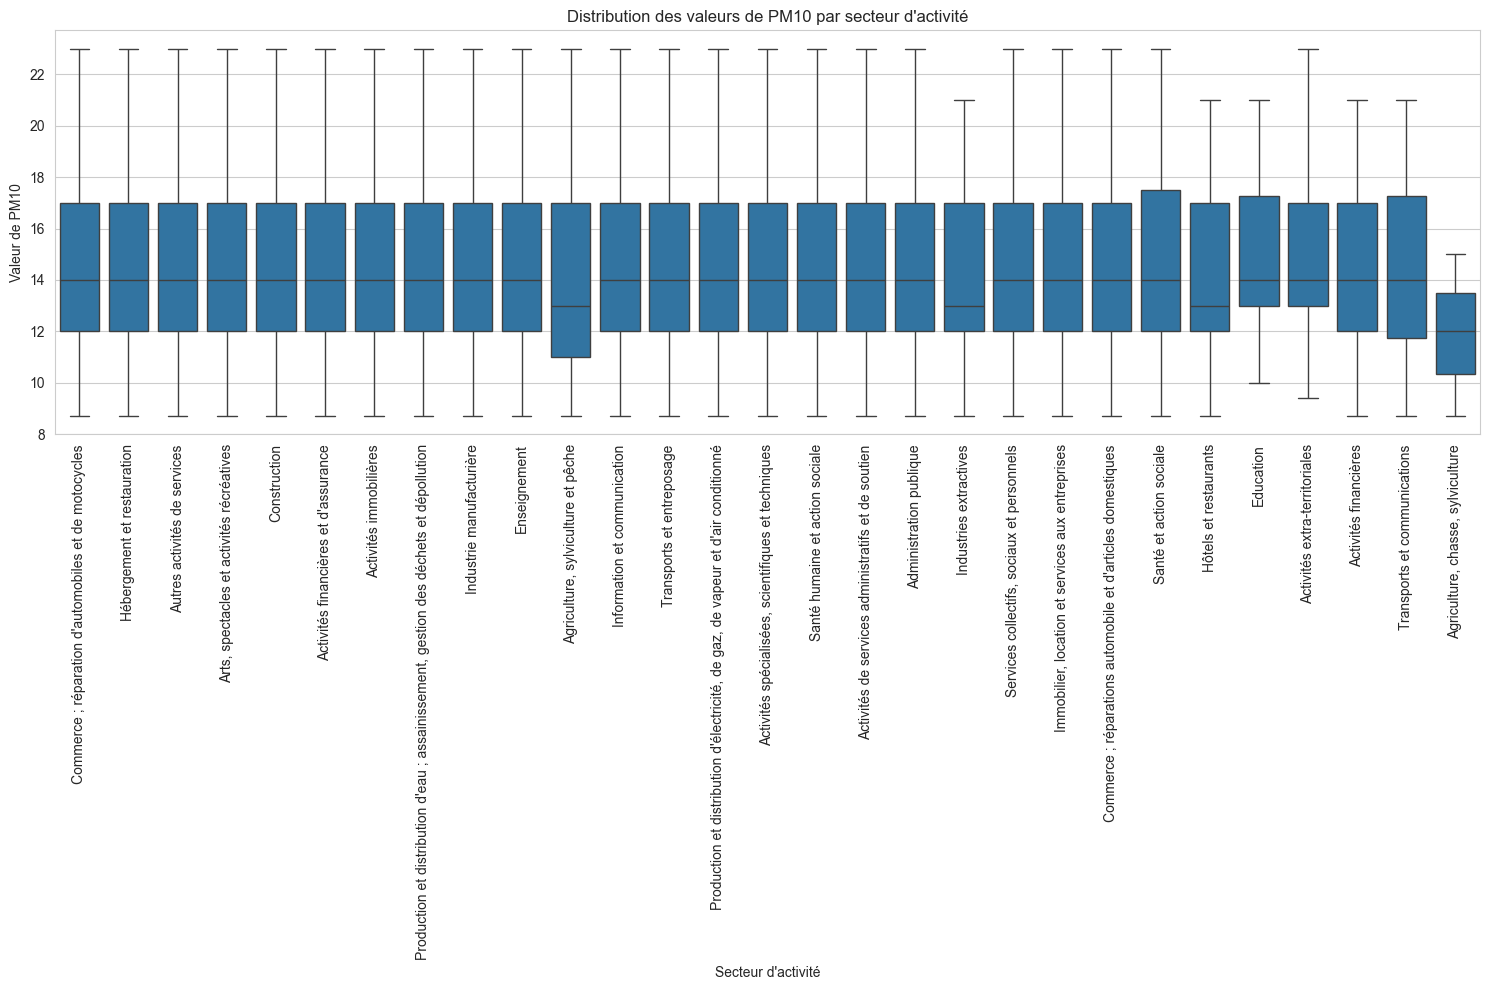

In [34]:
# Filtrer les lignes avec des valeurs nulles dans 'valeur' ou 'sectionetablissement'
dfPM10_mensuel = dfPM10_mensuel.dropna(subset=['valeur', 'sectionetablissement'])

# Créer le graphique box plot
plt.figure(figsize=(15, 10))
sns.boxplot(x='sectionetablissement', y='valeur', data=dfMerged)
plt.title('Distribution des valeurs de PM10 par secteur d\'activité')
plt.xlabel('Secteur d\'activité')
plt.ylabel('Valeur de PM10')
plt.xticks(rotation=90)
plt.tight_layout()

# Afficher le graphique
plt.show()


Le graphique présenté est une boîte à moustaches (box plot) qui montre la distribution des valeurs de PM10 pour différents secteurs d'activité. Voici comment interpréter ce graphique :

1. **Axes** :
   - L'axe des abscisses (horizontal) représente les différents secteurs d'activité.
   - L'axe des ordonnées (vertical) représente les valeurs de PM10.

2. **Éléments du Box Plot** :
   - **Boîte** : La boîte représente l'intervalle interquartile (IQR), soit les valeurs comprises entre le premier quartile (Q1) et le troisième quartile (Q3). La ligne à l'intérieur de la boîte représente la médiane des valeurs de PM10 pour le secteur d'activité.
   - **Moustaches** : Les lignes horizontales (moustaches) s'étendent des quartiles jusqu'à 1.5 fois l'IQR. Elles montrent l'étendue des valeurs sans les valeurs aberrantes.
   - **Points** : Les points au-delà des moustaches sont considérés comme des valeurs aberrantes.

3. **Interprétation** :
   - **Dispersion des données** : La hauteur des boîtes et la longueur des moustaches indiquent la dispersion des valeurs de PM10 pour chaque secteur d'activité. Plus la boîte est haute, plus la variation des valeurs est grande.
   - **Médiane** : La ligne à l'intérieur de chaque boîte indique la médiane. Les secteurs avec une médiane plus élevée sont ceux où les valeurs de PM10 tendent à être plus élevées.
   - **Comparaison des secteurs** : En comparant les hauteurs des boîtes et les positions des médianes, on peut voir quels secteurs ont les valeurs de PM10 les plus élevées et les plus basses.

4. **Observations** :
   - Certains secteurs d'activité, comme "Agriculture, sylviculture et pêche", "Transport et entreposage", et "Activités financières et d'assurance", montrent une distribution large avec des valeurs de PM10 s'étendant sur une grande gamme.
   - D'autres secteurs, comme "Hôtels et restaurants" et "Services collectifs, sociaux et personnels", montrent des boîtes plus petites, indiquant une distribution plus resserrée des valeurs de PM10.

En résumé, ce graphique permet de visualiser la variabilité des niveaux de pollution par PM10 dans différents secteurs d'activité et d'identifier quels secteurs tendent à avoir des niveaux de PM10 plus élevés ou plus bas.

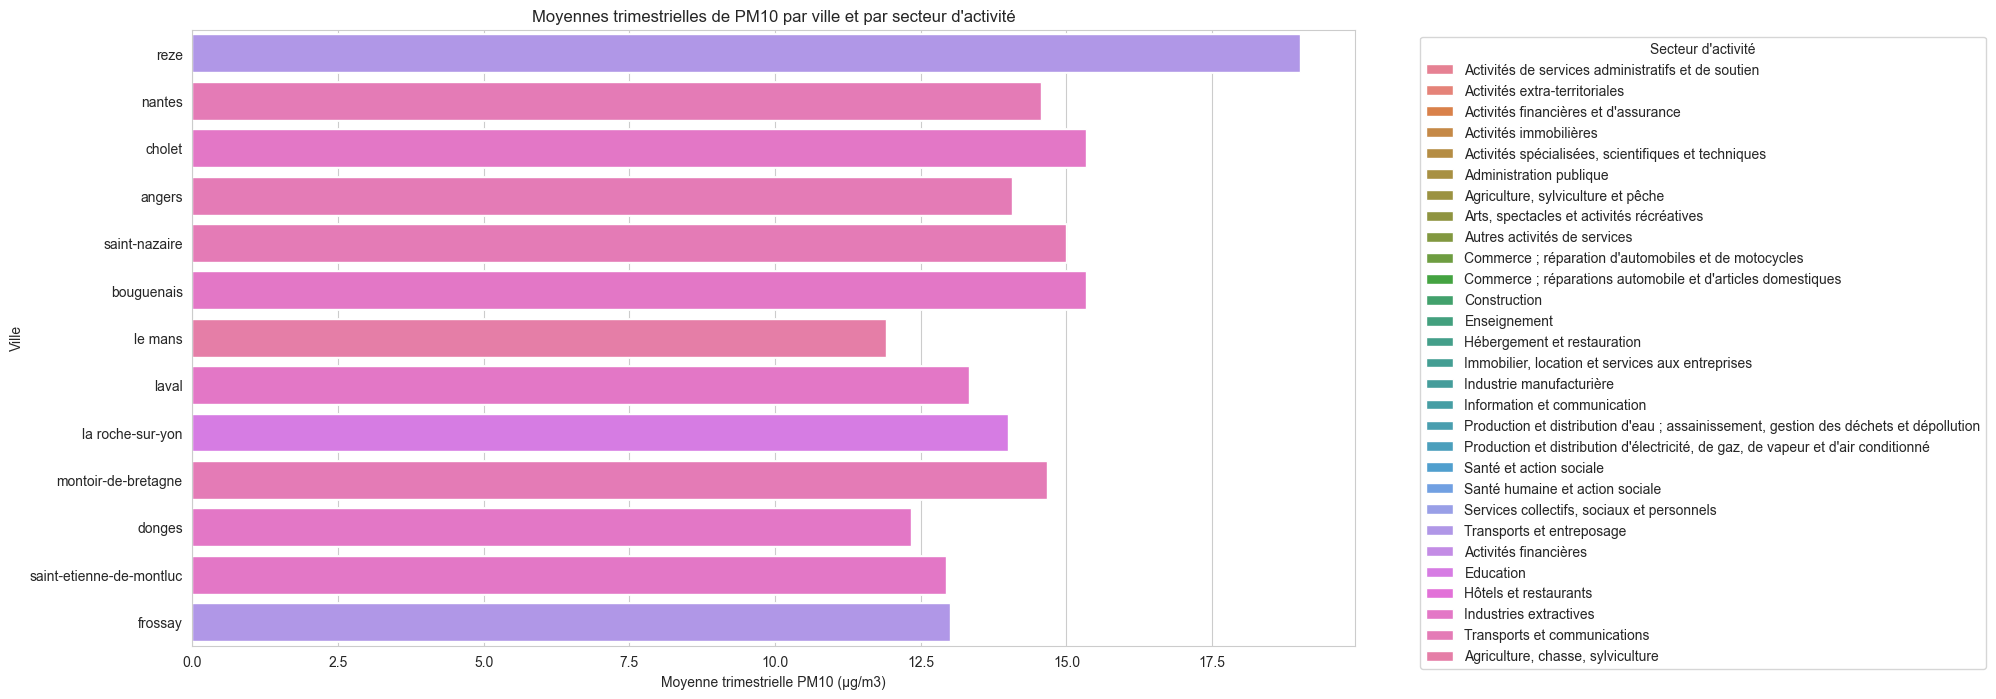

In [39]:
# Calculer la moyenne trimestrielle de PM10 pour chaque ville et chaque secteur d'activité
sector_city_means = dfPM10_mensuel.groupby(['nom_commune', 'sectionetablissement'])['valeur'].mean().reset_index()

# Trier les villes par la moyenne trimestrielle totale de PM10
total_city_means = sector_city_means.groupby('nom_commune')['valeur'].sum().sort_values(ascending=False).index

# Trier les secteurs d'activité pour chaque ville
sector_city_means['nom_commune'] = pd.Categorical(sector_city_means['nom_commune'], categories=total_city_means, ordered=True)
sector_city_means = sector_city_means.sort_values(by=['nom_commune', 'valeur'], ascending=[True, False])

# Créer un graphique en barres empilées pour les villes et les secteurs d'activité
plt.figure(figsize=(15, 8))
sns.barplot(data=sector_city_means, x='valeur', y='nom_commune', hue='sectionetablissement', dodge=False)

plt.xlabel('Moyenne trimestrielle PM10 (µg/m3)')
plt.ylabel('Ville')
plt.title('Moyennes trimestrielles de PM10 par ville et par secteur d\'activité')
plt.legend(title='Secteur d\'activité', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
